In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.measure import centroid

from tifffile import imread

In [2]:
# img = imread('20221114_PSF_Stellaris5_60X_1.tif')

# spacing = np.array([200, 36, 36])

In [3]:
img = imread('W1_Levi_40x_1_Conf488.stk')

spacing = np.array([200, 163, 163])

In [4]:
# img = imread('W1_Levi_63x_1_Conf488.stk')

# spacing = np.array([200, 103, 103])

In [5]:
# img = imread('XY266_Z622_simulated.tif')
# img = np.random.poisson(img*500) # Add some noise

# spacing = np.array([100, 40, 40])

In [6]:
def get_raw_crop(img, size_nm, spacing):
    z, y, x = np.unravel_index(np.argmax(img), img.shape)
    
    half_size = np.ceil(size_nm / spacing / 2).astype(int)
    
    z_slice = slice(max(0, z - half_size[0]), min(z + half_size[0] + 1, img.shape[0]))
    y_slice = slice(max(0, y - half_size[1]), min(y + half_size[1] + 1, img.shape[1]))
    x_slice = slice(max(0, x - half_size[2]), min(x + half_size[2] + 1, img.shape[2]))
    
    
    crop = img[z_slice, y_slice, x_slice]
    return crop

In [7]:
psf = get_raw_crop(img, 2000, spacing)

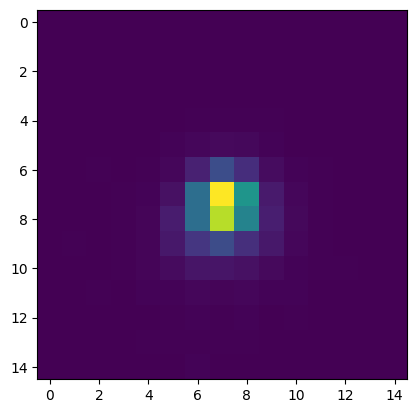

In [8]:
plt.imshow(psf[psf.shape[0]//2])

In [9]:
y_lim = [0, psf.max() * 1.1]

In [10]:
def get_cov_matrix(img, spacing):
    def cov(x, y, i):
        return np.sum(x * y * i) / np.sum(i)

    extends = [np.arange(l) * s for l, s in zip(img.shape, spacing)]
    
    grids = np.meshgrid(
        *extends,
        indexing="ij",
    )
    cen = centroid(img)
    
    if img.ndim == 1:
        x = grids[0].ravel() - cen[0] * spacing[0]
        return cov(x, x, img.ravel())
    elif img.ndim == 2:
        y = grids[0].ravel() - cen[0] * spacing[0]
        x = grids[1].ravel() - cen[1] * spacing[1]

        cxx = cov(x, x, img.ravel())
        cyy = cov(y, y, img.ravel())
        cxy = cov(x, y, img.ravel())

        return np.array([[cxx, cxy], [cxy, cyy]])
    elif img.ndim == 3:
        z = grids[0].ravel() - cen[0] * spacing[0]
        y = grids[1].ravel() - cen[1] * spacing[1]
        x = grids[2].ravel() - cen[2] * spacing[2]

        cxx = cov(x, x, img.ravel())
        cyy = cov(y, y, img.ravel())
        czz = cov(z, z, img.ravel())
        cxy = cov(x, y, img.ravel())
        cxz = cov(x, z, img.ravel())
        cyz = cov(y, z, img.ravel())

        return np.array([[cxx, cxy, cxz], [cxy, cyy, cyz], [cxz, cyz, czz]])
    else:
        NotImplementedError()

In [11]:
def fwhm(sigma):
    return 2 * np.sqrt(2 * np.log(2)) * sigma

In [12]:
def plot_fit_1d(psf1d, coords, params, prefix, ylim=[0, 9200]):
    fine_coords = np.linspace(coords[0], coords[-1], 500)
    plt.plot(coords, psf1d, '-', label='measurment', color='k')
    plt.bar(coords, psf1d, width=15, color='k')
    plt.plot(coords, [params[1],] * len(coords), '--', label=f'{prefix} background' )
    plt.plot(coords, [params[1] + params[0],] * len(coords), '--', label=f'{prefix} amplitude')
    plt.plot([params[2],]* 2, [params[1], params[1] + params[0]], '--', label=f'{prefix} location')
    plt.plot(fine_coords, gauss_1d(*params)(fine_coords), '--', label=f'{prefix} Gaussian')
    plt.ylim(ylim)
    plt.legend();

# 1D fits

## X

In [13]:
psf_x = psf[psf.shape[0]//2, psf.shape[1]//2]

In [14]:
coords_x = np.arange(len(psf_x)) * spacing[2]

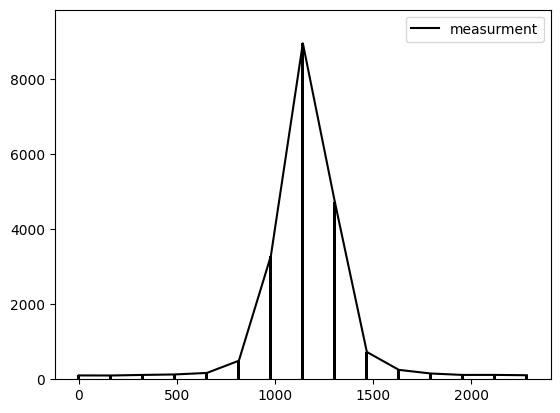

In [15]:
plt.plot(coords_x, psf_x, '-', label='measurment', color='k')
plt.bar(coords_x, psf_x, width=15, color='k')
plt.ylim(y_lim)
plt.legend();

### Estimate from data

In [16]:
def gauss_1d(amp, bg, mu, sigma):
    return lambda x: amp * np.exp(-(x - mu)**2 / (2*sigma**2)) + bg

In [17]:
bg = np.median(psf_x)
amp = psf_x.max() - bg
sigma = np.sqrt(get_cov_matrix(np.clip(psf_x - bg, 0, psf_x.max()), [spacing[2]]))
mu = centroid(psf_x) * spacing[2]

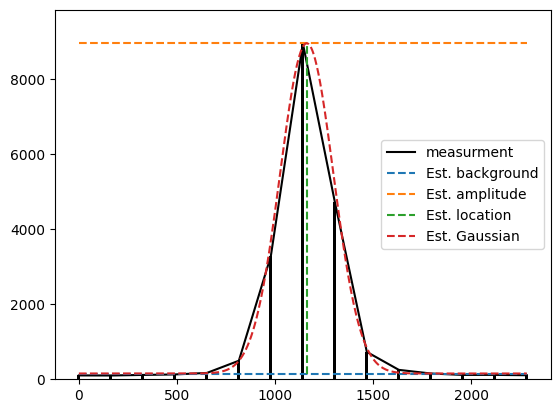

In [18]:
plot_fit_1d(psf_x, coords_x, [amp, bg, mu, sigma], "Est.", y_lim)

### Curve fit

In [19]:
from scipy.optimize import curve_fit

In [20]:
def eval_fun(x, amp, bg, mu, sigma):
    return gauss_1d(amp=amp, bg=bg, mu=mu, sigma=sigma)(x)

In [21]:
params = [amp, bg, mu[0], sigma]

In [22]:
popt, pcov = curve_fit(
    eval_fun,
    coords_x,
    psf_x,
    p0=params,
)

In [23]:
popt

array([8874.73513495,  153.31477921, 1159.36000056,  126.5353748 ])

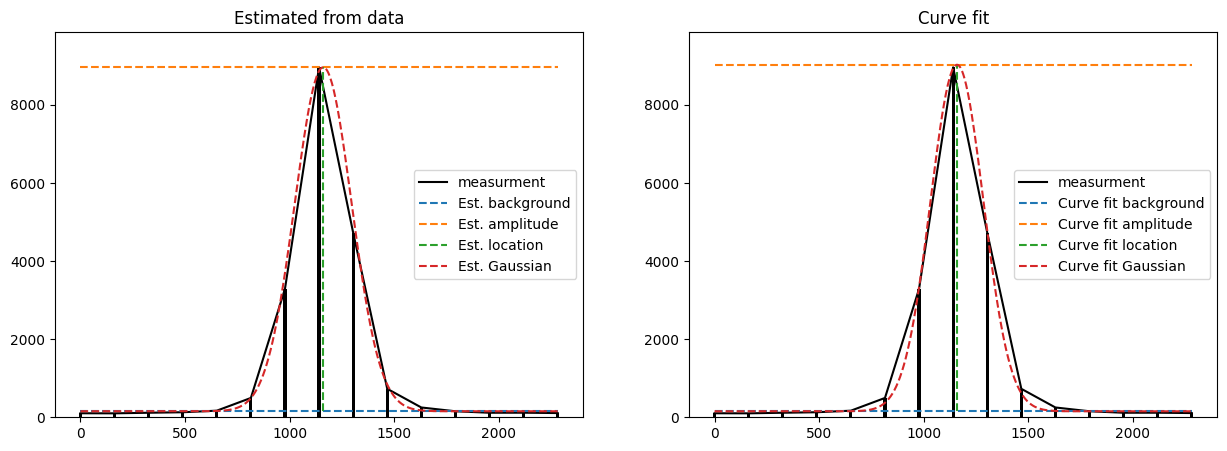

In [24]:
fine_coords_x = np.linspace(coords_x[0], coords_x[-1], 500)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_fit_1d(psf_x, coords_x, params, "Est.", y_lim)
plt.title('Estimated from data');
plt.subplot(1,2,2)
plot_fit_1d(psf_x, coords_x, popt, "Curve fit", y_lim)
plt.title('Curve fit');

### Minimize KL-Div

In [25]:
from scipy.special import kl_div
from scipy.optimize import minimize

def get_objective(coords, measurement):
    def objective(params):

        
        fit = gauss_1d(*params)(coords)
        
        kld = kl_div(fit, measurement)
        kld[np.isinf(kld)] = 0
        
        return np.sum(kld)
    
    return objective

In [26]:
res = minimize(get_objective(coords_x, psf_x), 
               x0=params,
               method='L-BFGS-B', 
               options={'disp': True},
               bounds=[
                   (params[0]/2, params[0]*2), 
                   (0, params[0]/2), 
                   (params[2] - params[3] / 2, params[2] + params[3] / 2), 
                   (spacing[1]/4, 2*params[3])]
              )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17906D+02    |proj g|=  1.22551D+01

At iterate    1    f=  8.20244D+01    |proj g|=  1.49321D+00

At iterate    2    f=  7.72261D+01    |proj g|=  1.27639D+00

At iterate    3    f=  6.71831D+01    |proj g|=  1.22628D+00

At iterate    4    f=  6.66449D+01    |proj g|=  1.70014D+00

At iterate    5    f=  6.49552D+01    |proj g|=  2.37842D-02

At iterate    6    f=  6.49545D+01    |proj g|=  2.36705D-02

At iterate    7    f=  6.49470D+01    |proj g|=  4.67537D-02

At iterate    8    f=  6.49289D+01    |proj g|=  1.19894D-01

At iterate    9    f=  6.48901D+01    |proj g|=  2.11784D-01

At iterate   10    f=  6.47756D+01    |proj g|=  3.91836D-01

At iterate   11    f=  6.45670D+01    |proj g|=  5.45480D-01

At iterate   12    f=  6.39818D+01    |proj g|=  5.88742D-01

At iterate   13    f=  6.3

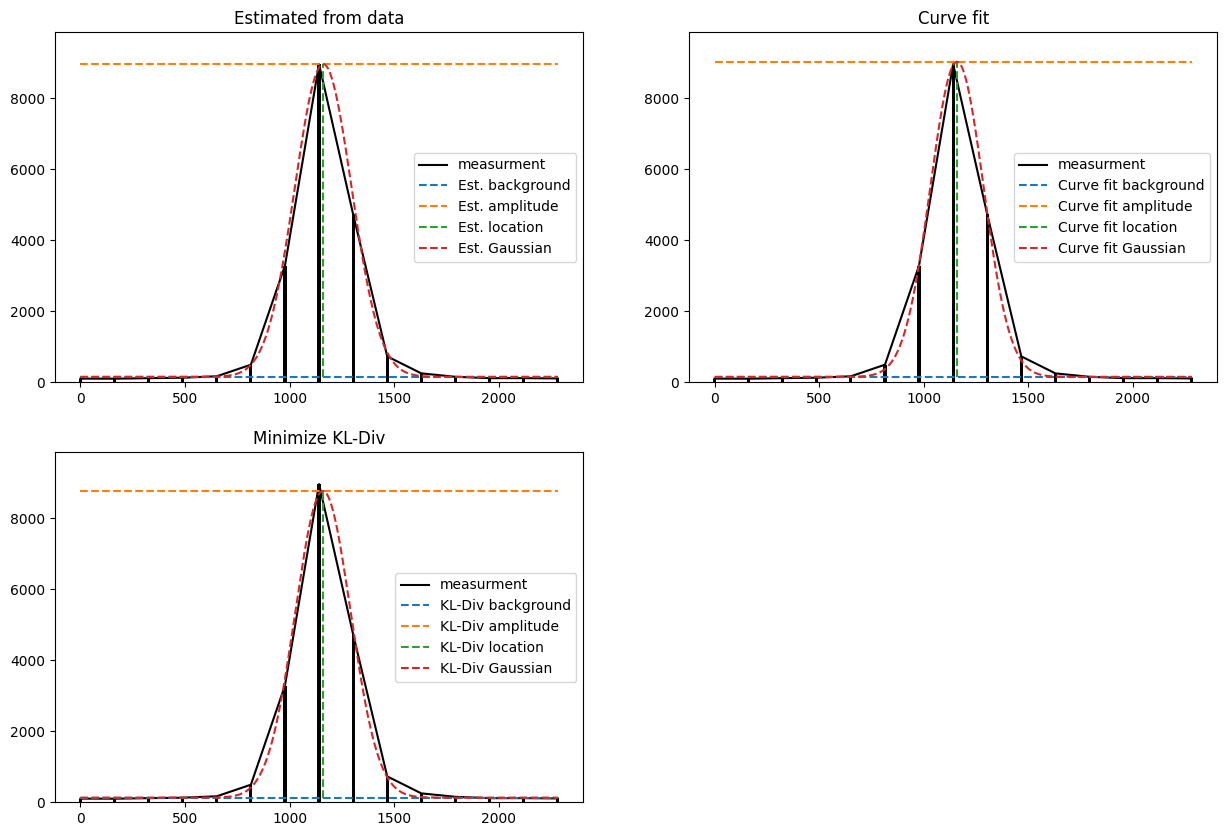

In [27]:
fine_coords_x = np.linspace(coords_x[0], coords_x[-1], 500)
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_fit_1d(psf_x, coords_x, [amp, bg, mu, sigma], "Est.", y_lim)
plt.title('Estimated from data');

plt.subplot(2,2,2)
plot_fit_1d(psf_x, coords_x, popt, "Curve fit", y_lim)
plt.title('Curve fit');

plt.subplot(2,2,3)
plot_fit_1d(psf_x, coords_x, res.x, "KL-Div", y_lim)
plt.title('Minimize KL-Div');

In [28]:
est_fwhm_x = fwhm(sigma)
cv_fwhm_x = fwhm(popt[3])
kld_fwhm_x = fwhm(res.x[3])

In [29]:
mu_x = res.x[2]
amp_x = res.x[0]
bg_x = res.x[1]

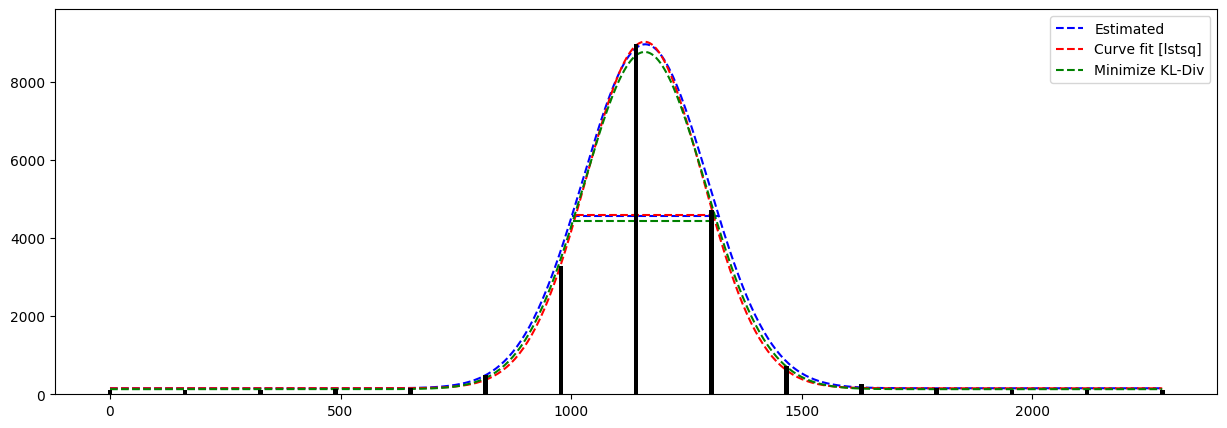

In [30]:
# plt.plot(coords_x, psf_x, '-', label='measurment', color='gray', linewidth=2, zorder=10)
plt.figure(figsize=(15,5))
plt.bar(coords_x, psf_x, width=10, color='k', zorder=10)
plt.plot(fine_coords_x, gauss_1d(amp, bg, mu[0], sigma)(fine_coords_x), '--', label='Estimated', color='b')
plt.plot([mu[0] - est_fwhm_x / 2, mu[0] + est_fwhm_x / 2], [bg + amp/2 , ]* 2, '--', color='b')
plt.plot(fine_coords_x, gauss_1d(*popt)(fine_coords_x), '--', label='Curve fit [lstsq]', color='r')
plt.plot([popt[2] - cv_fwhm_x / 2, popt[2] + cv_fwhm_x / 2], [popt[1] + popt[0]/2 , ]* 2, '--', color='r')
plt.plot(fine_coords_x, gauss_1d(*res.x)(fine_coords_x), '--', label='Minimize KL-Div', color='g')
plt.plot([res.x[2] - kld_fwhm_x / 2, res.x[2] + kld_fwhm_x / 2], [res.x[1] + res.x[0]/2 , ]* 2, '--', color='g')
plt.ylim(y_lim)
plt.legend();

In [31]:
print(f"Estimated FWHM: {est_fwhm_x:.4f}")
print(f"Curve fit FWHM: {cv_fwhm_x:.4f}")
print(f"Min. KL-D FWHM: {kld_fwhm_x:.4f}")

Estimated FWHM: 318.9650
Curve fit FWHM: 297.9680
Min. KL-D FWHM: 311.0512


In [32]:
def mse(params, coords, target):
    return np.mean((target - gauss_1d(*params)(coords))**2)

In [33]:
def mae(params, coords, target):
    return np.mean(np.abs(target - gauss_1d(*params)(coords)))

In [34]:
def kl_div_error(params, coords, target):
    return get_objective(coords, target)(params)

In [35]:
print("Mean Squared Error")
print(f"Estimated: {mse([amp, bg, mu[0], sigma], coords_x, psf_x):.3f}")
print(f"Curve fit: {mse(popt, coords_x, psf_x):.3f}")
print(f"Min. KL-D: {mse(res.x, coords_x, psf_x):.3f}")

Mean Squared Error
Estimated: 28042.181
Curve fit: 3494.872
Min. KL-D: 10939.776


In [36]:
print("Mean Absolute Error")
print(f"Estimated: {mae([amp, bg, mu[0], sigma], coords_x, psf_x):.3f}")
print(f"Curve fit: {mae(popt, coords_x, psf_x):.3f}")
print(f"Min. KL-D: {mae(res.x, coords_x, psf_x):.3f}")

Mean Absolute Error
Estimated: 96.654
Curve fit: 48.926
Min. KL-D: 67.959


In [37]:
print("Kullback-Leibler Divergence")
print(f"Estimated: {kl_div_error([amp, bg, mu[0], sigma], coords_x, psf_x):.3f}")
print(f"Curve fit: {kl_div_error(popt, coords_x, psf_x):.3f}")
print(f"Min. KL-D: {kl_div_error(res.x, coords_x, psf_x):.3f}")

Kullback-Leibler Divergence
Estimated: 117.906
Curve fit: 94.037
Min. KL-D: 62.905


## Y

In [38]:
psf_y = psf[psf.shape[0]//2, :, psf.shape[2]//2]

In [39]:
coords_y = np.arange(len(psf_y)) * spacing[1]

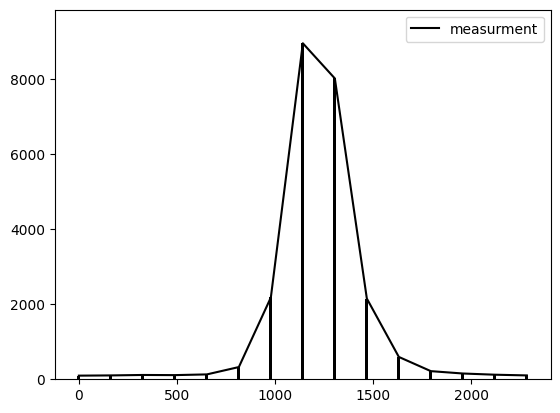

In [40]:
plt.plot(coords_y, psf_y, '-', label='measurment', color='k')
plt.bar(coords_y, psf_y, width=15, color='k')
plt.ylim(y_lim)
plt.legend();

### Estimate from data

In [41]:
bg = np.median(psf_y)
amp = psf_y.max() - bg
sigma = np.sqrt(get_cov_matrix(np.clip(psf_y - bg, 0, psf_y.max()), [spacing[1]]))
mu = centroid(psf_y) * spacing[1]

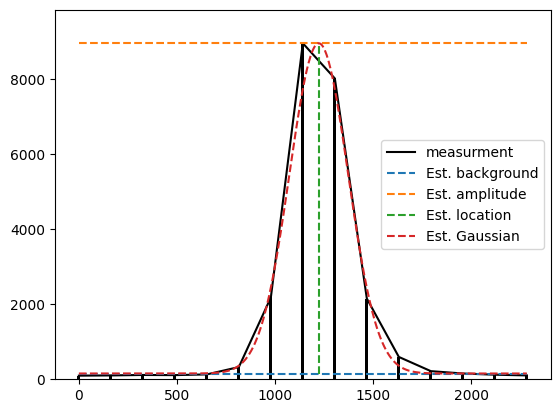

In [42]:
plot_fit_1d(psf_y, coords_y, [amp, bg, mu, sigma], "Est.", y_lim)

### Curve fit

In [43]:
params = [amp, bg, mu[0], sigma]

In [44]:
popt, pcov = curve_fit(
    eval_fun,
    coords_y,
    psf_y,
    p0=params,
)

In [45]:
popt

array([9972.26826624,  166.32107348, 1214.0195991 ,  136.30011326])

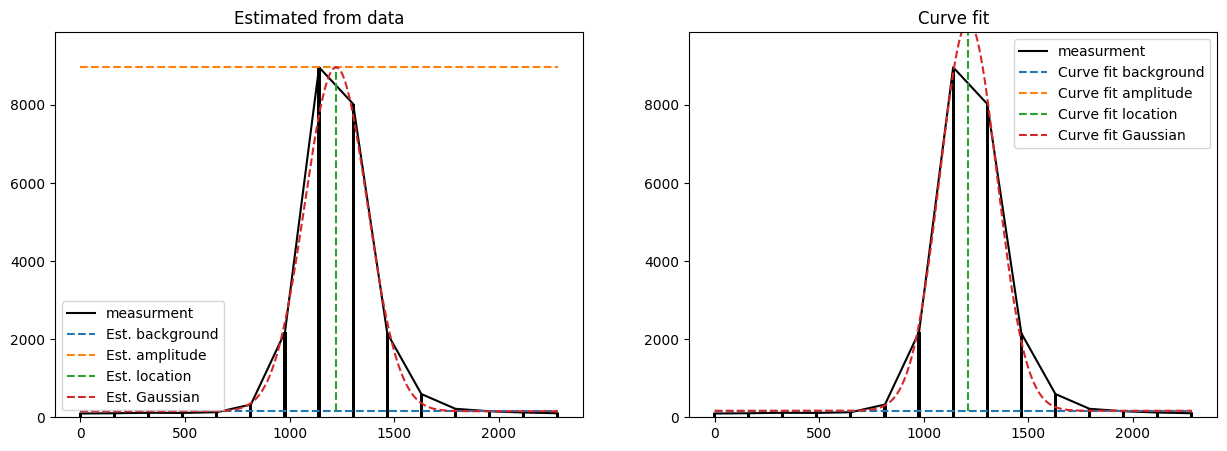

In [46]:
fine_coords_x = np.linspace(coords_x[0], coords_x[-1], 500)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_fit_1d(psf_y, coords_y, params, "Est.", y_lim)
plt.title('Estimated from data');

plt.subplot(1,2,2)
plot_fit_1d(psf_y, coords_y, popt, "Curve fit", y_lim)
plt.title('Curve fit');

### Minimize KL-Div

In [47]:
res = minimize(get_objective(coords_y, psf_y), 
               x0=params,
               method='L-BFGS-B', 
               options={'disp': True},
               bounds=[
                   (params[0]/2, params[0]*2), 
                   (0, params[0]/2), 
                   (params[2] - params[3] / 2, params[2] + params[3] / 2), 
                   (spacing[1]/4, 2*params[3])]
              )

RUNNING THE L-BFGS-B CODE

           * * *




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46407D+02    |proj g|=  2.84368D+00

At iterate    1    f=  2.43346D+02    |proj g|=  2.85266D+00

At iterate    2    f=  2.40799D+02    |proj g|=  1.34957D+00

At iterate    3    f=  2.38197D+02    |proj g|=  1.30571D+00

At iterate    4    f=  2.33514D+02    |proj g|=  1.87352D+00

At iterate    5    f=  2.27812D+02    |proj g|=  2.30687D+00

At iterate    6    f=  2.25056D+02    |proj g|=  5.64154D-01

At iterate    7    f=  2.24844D+02    |proj g|=  1.22789D-01

At iterate    8    f=  2.24813D+02    |proj g|=  1.22871D-01

At iterate    9    f=  2.24758D+02    |proj g|=  1.72112D-01

At iterate   10    f=  2.24594D+02    |proj g|=  4.17735D-01

At iterate   11    f=  2.24193D+02    |proj g|=  7.80525D-01

At iterate   12    f=  2.23119D+02    |proj g|=  1.38318D+00

At iterate   13    f=  2.20528D+02    |proj g|=  2.26655D+00

At iterat

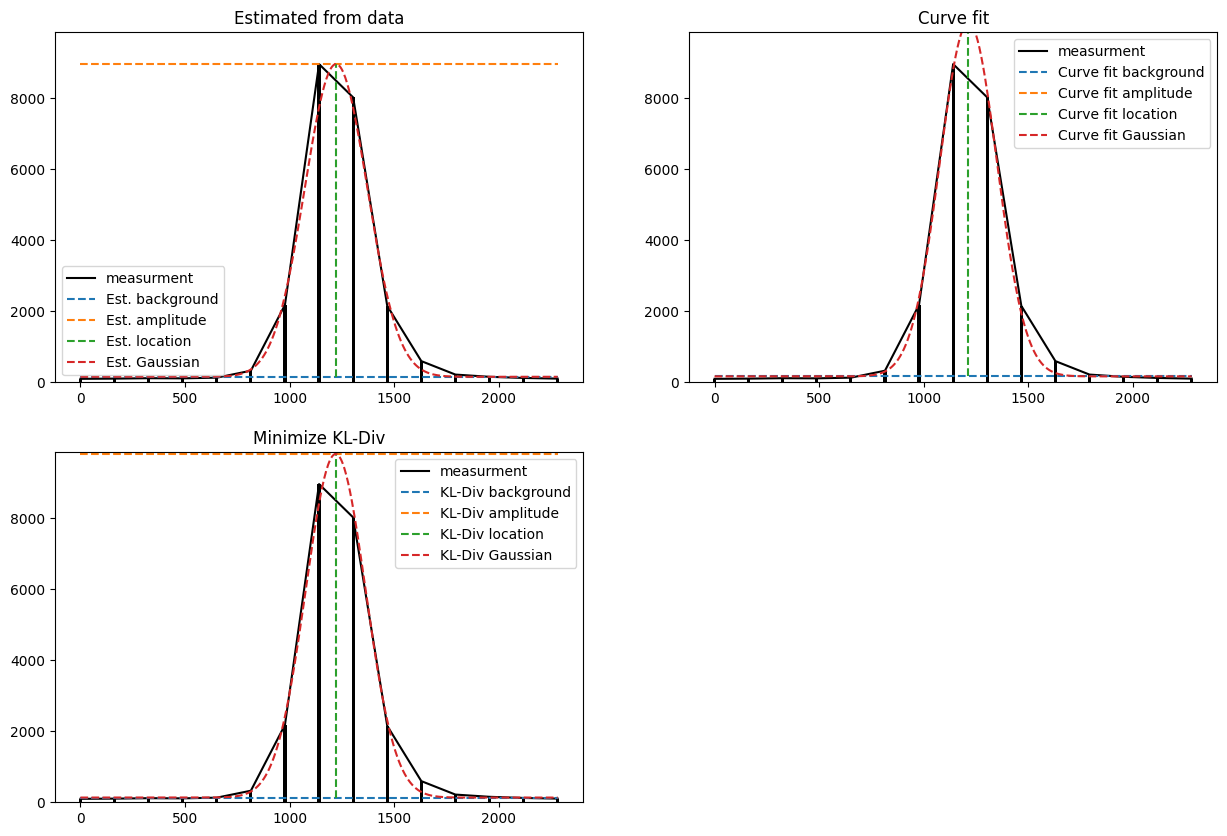

In [48]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_fit_1d(psf_y, coords_y, [amp, bg, mu, sigma], "Est.", y_lim)
plt.title('Estimated from data');

plt.subplot(2,2,2)
plot_fit_1d(psf_y, coords_y, popt, "Curve fit", y_lim)
plt.title('Curve fit');

plt.subplot(2,2,3)
plot_fit_1d(psf_y, coords_y, res.x, "KL-Div", y_lim)
plt.title('Minimize KL-Div');

In [49]:
est_fwhm_y = fwhm(sigma)
cv_fwhm_y = fwhm(popt[3])
kld_fwhm_y = fwhm(res.x[3])

In [50]:
mu_y = res.x[2]
amp_y = res.x[0]
bg_y = res.x[1]

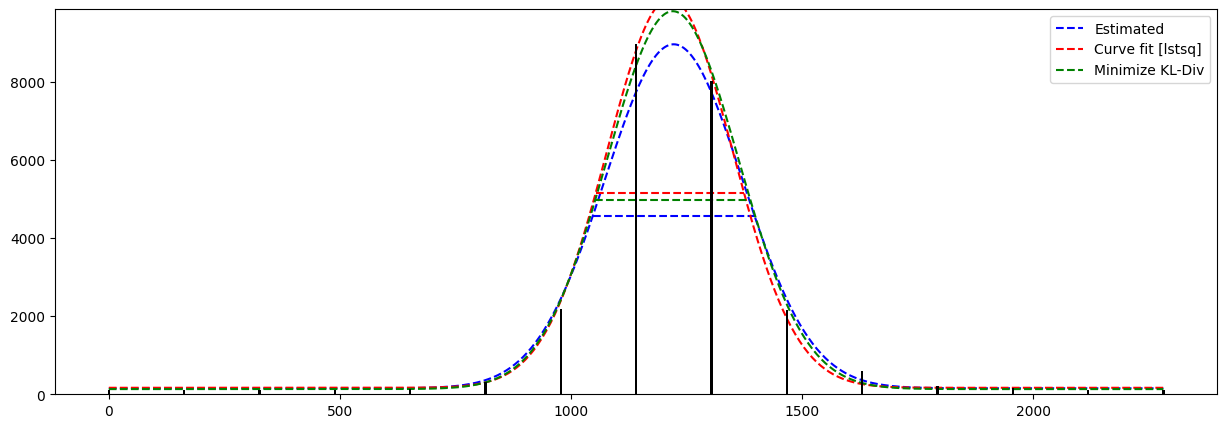

In [51]:
fine_coords_y = np.linspace(coords_y[0], coords_y[-1], 500)
# plt.plot(coords_x, psf_x, '-', label='measurment', color='gray', linewidth=2, zorder=10)
plt.figure(figsize=(15,5))
plt.bar(coords_y, psf_y, width=5, color='k', zorder=10)
plt.plot(fine_coords_y, gauss_1d(amp, bg, mu[0], sigma)(fine_coords_y), '--', label='Estimated', color='b')
plt.plot([mu[0] - est_fwhm_y / 2, mu[0] + est_fwhm_y / 2], [bg + amp/2 , ]* 2, '--', color='b')
plt.plot(fine_coords_y, gauss_1d(*popt)(fine_coords_y), '--', label='Curve fit [lstsq]', color='r')
plt.plot([popt[2] - cv_fwhm_y / 2, popt[2] + cv_fwhm_y / 2], [popt[1] + popt[0]/2 , ]* 2, '--', color='r')
plt.plot(fine_coords_y, gauss_1d(*res.x)(fine_coords_y), '--', label='Minimize KL-Div', color='g')
plt.plot([res.x[2] - kld_fwhm_y / 2, res.x[2] + kld_fwhm_y / 2], [res.x[1] + res.x[0]/2 , ]* 2, '--', color='g')
plt.ylim(y_lim)
plt.legend();

In [52]:
print("X")
print(f"Estimated FWHM: {est_fwhm_x:.4f}")
print(f"Curve fit FWHM: {cv_fwhm_x:.4f}")
print(f"Min. KL-D FWHM: {kld_fwhm_x:.4f}")

X
Estimated FWHM: 318.9650
Curve fit FWHM: 297.9680
Min. KL-D FWHM: 311.0512


In [53]:
print("Y")
print(f"Estimated FWHM: {est_fwhm_y:.4f}")
print(f"Curve fit FWHM: {cv_fwhm_y:.4f}")
print(f"Min. KL-D FWHM: {kld_fwhm_y:.4f}")

Y
Estimated FWHM: 350.5216
Curve fit FWHM: 320.9622
Min. KL-D FWHM: 335.9849


In [54]:
print("Mean Squared Error")
print(f"Estimated: {mse([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {mse(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {mse(res.x, coords_y, psf_y):.3f}")

Mean Squared Error
Estimated: 119897.495
Curve fit: 18317.941
Min. KL-D: 36276.536


In [55]:
print("Mean Absolute Error")
print(f"Estimated: {mae([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {mae(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {mae(res.x, coords_y, psf_y):.3f}")

Mean Absolute Error
Estimated: 179.393
Curve fit: 102.630
Min. KL-D: 118.091


In [56]:
print("Kullback-Leibler Divergence")
print(f"Estimated: {kl_div_error([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {kl_div_error(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {kl_div_error(res.x, coords_y, psf_y):.3f}")

Kullback-Leibler Divergence
Estimated: 246.407
Curve fit: 237.403
Min. KL-D: 173.216


## Z

In [57]:
psf_z = psf[:, psf.shape[1]//2, psf.shape[2]//2]

In [58]:
coords_z = np.arange(len(psf_z)) * spacing[0]

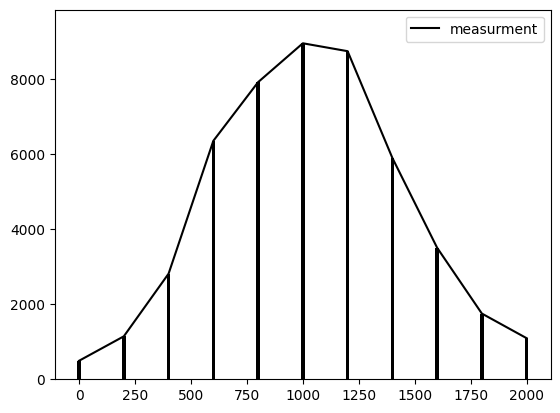

In [59]:
plt.plot(coords_z, psf_z, '-', label='measurment', color='k')
plt.bar(coords_z, psf_z, width=15, color='k')
plt.ylim(y_lim)
plt.legend();

### Estimate from data

In [60]:
bg = np.median(psf_z)
amp = psf_z.max() - bg
sigma = np.sqrt(get_cov_matrix(np.clip(psf_z - bg, 0, psf_z.max()), [spacing[0]]))
mu = centroid(psf_z) * spacing[0]

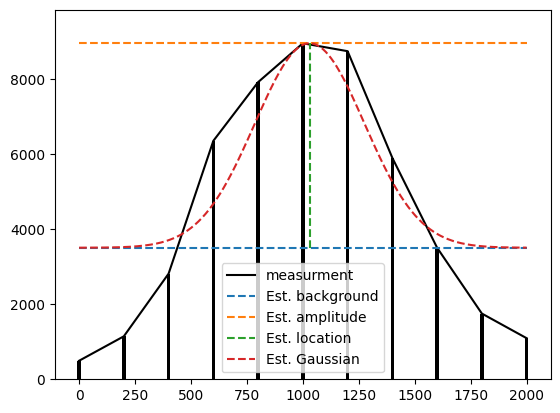

In [61]:
plot_fit_1d(psf_z, coords_z, [amp, bg, mu, sigma], "Est.", y_lim)

### Curve fit

In [62]:
params = [amp, bg, mu[0], sigma]

In [63]:
popt, pcov = curve_fit(
    eval_fun,
    coords_z,
    psf_z,
    p0=params,
)

In [64]:
popt

array([9118.65680471,  142.50772019, 1017.22255391,  415.75520614])

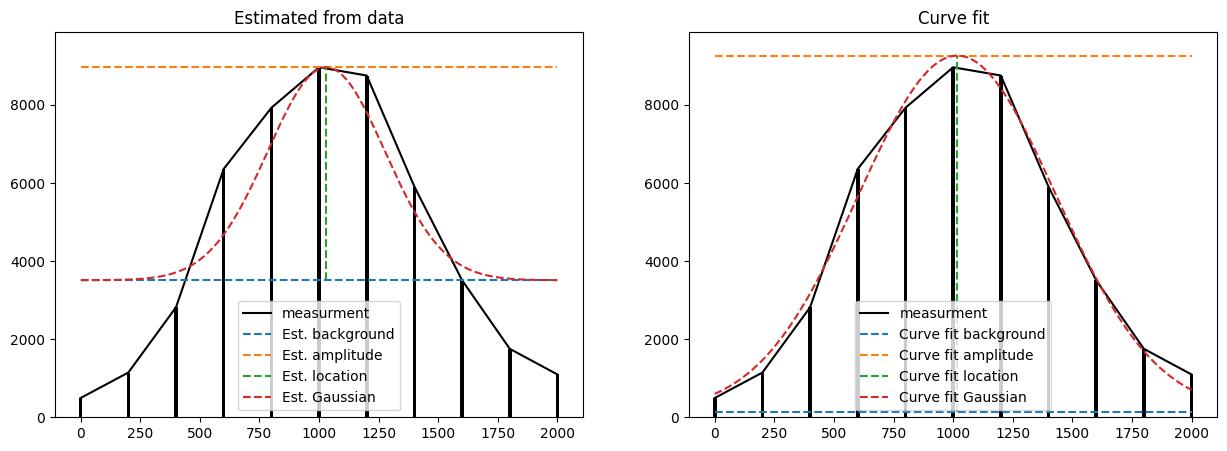

In [65]:
fine_coords_z = np.linspace(coords_z[0], coords_z[-1], 500)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_fit_1d(psf_z, coords_z, params, "Est.", y_lim)
plt.title('Estimated from data');

plt.subplot(1,2,2)
plot_fit_1d(psf_z, coords_z, popt, "Curve fit", y_lim)
plt.title('Curve fit');

### Minimize KL-Div

In [66]:
res = minimize(get_objective(coords_z, psf_z), 
               x0=params,
               method='L-BFGS-B', 
               options={'disp': True},
               bounds=[
                   (params[0]/2, params[0]*2), 
                   (0, params[0]/2), 
                   (params[2] - params[3] / 2, params[2] + params[3] / 2), 
                   (spacing[1]/4, 2*params[3])]
              )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.51715D+03    |proj g|=  1.56839D+01

At iterate    1    f=  5.29778D+03    |proj g|=  1.10730D+01

At iterate    2    f=  5.03422D+03    |proj g|=  3.38727D+00

At iterate    3    f=  4.32349D+03    |proj g|=  5.13318D+00

At iterate    4    f=  2.61022D+03    |proj g|=  7.10174D+00

At iterate    5    f=  2.13122D+03    |proj g|=  5.12791D+00

At iterate    6    f=  2.02445D+03    |proj g|=  1.22658D+00

At iterate    7    f=  2.01116D+03    |proj g|=  1.19104D+00

At iterate    8    f=  1.93637D+03    |proj g|=  2.75493D+00

At iterate    9    f=  1.79417D+03    |proj g|=  6.53383D+00

At iterate   10    f=  1.48951D+03    |proj g|=  1.16347D+01

At iterate   11    f=  9.50543D+02    |proj g|=  1.54992D+01

At iterate   12    f=  2.69687D+02    |proj g|=  8.18111D+00

At iterate   13    f=  2.0

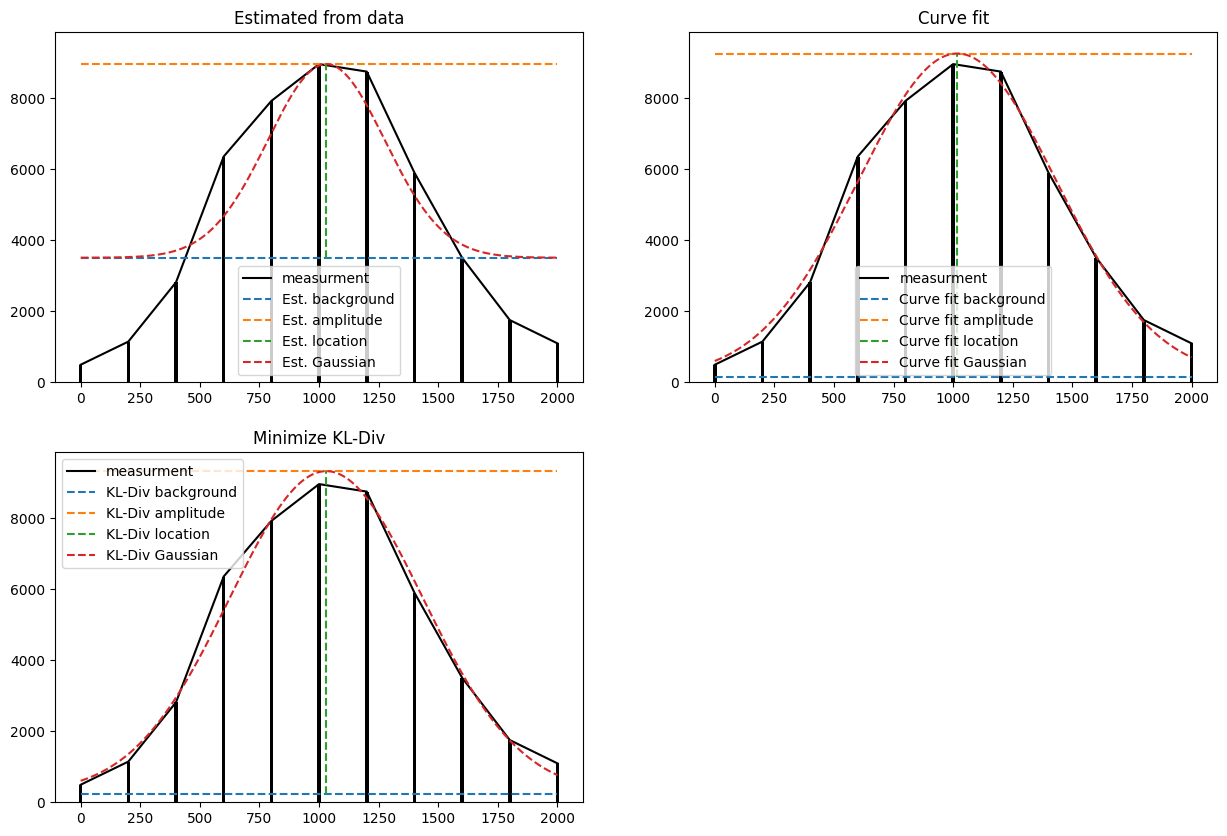

In [67]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_fit_1d(psf_z, coords_z, params, "Est.", y_lim)
plt.title('Estimated from data');

plt.subplot(2,2,2)
plot_fit_1d(psf_z, coords_z, popt, "Curve fit", y_lim)
plt.title('Curve fit');

plt.subplot(2,2,3)
plot_fit_1d(psf_z, coords_z, res.x, "KL-Div", y_lim)
plt.title('Minimize KL-Div');

In [68]:
est_fwhm_z = fwhm(sigma)
cv_fwhm_z = fwhm(popt[3])
kld_fwhm_z = fwhm(res.x[3])

In [69]:
mu_z = res.x[2]
amp_z = res.x[0]
bg_z = res.x[1]

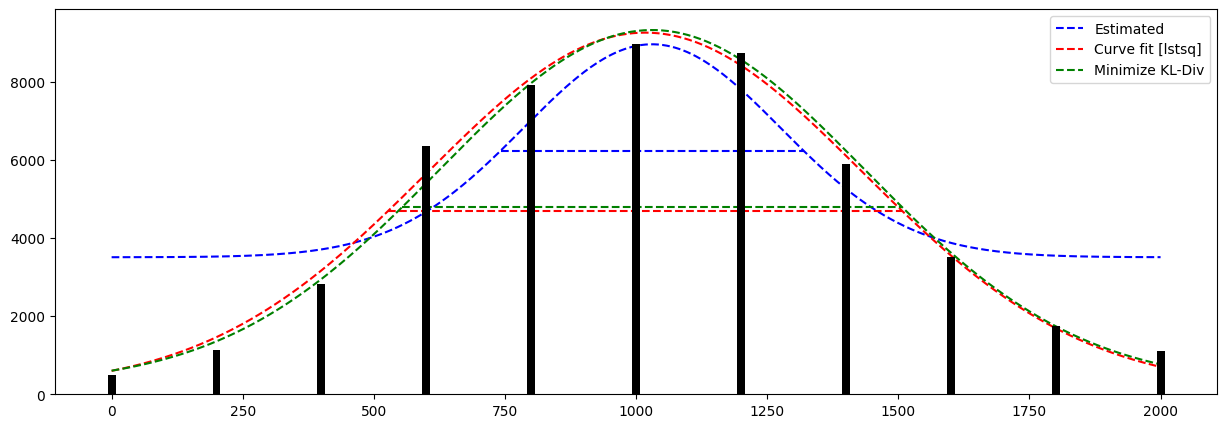

In [70]:
plt.figure(figsize=(15,5))
fine_coords_z = np.linspace(coords_z[0], coords_z[-1], 500)
# plt.plot(coords_x, psf_x, '-', label='measurment', color='gray', linewidth=2, zorder=10)
plt.bar(coords_z, psf_z, width=15, color='k', zorder=10)

plt.plot(fine_coords_z, gauss_1d(amp, bg, mu[0], sigma)(fine_coords_z), '--', label='Estimated', color='b')
plt.plot([mu[0] - est_fwhm_z / 2, mu[0] + est_fwhm_z / 2], [bg + amp/2 , ]* 2, '--', color='b')
plt.plot(fine_coords_z, gauss_1d(*popt)(fine_coords_z), '--', label='Curve fit [lstsq]', color='r')
plt.plot([popt[2] - cv_fwhm_z / 2, popt[2] + cv_fwhm_z / 2], [popt[1] + popt[0]/2 , ]* 2, '--', color='r')
plt.plot(fine_coords_z, gauss_1d(*res.x)(fine_coords_z), '--', label='Minimize KL-Div', color='g')
plt.plot([res.x[2] - kld_fwhm_z / 2, res.x[2] + kld_fwhm_z / 2], [res.x[1] + res.x[0]/2 , ]* 2, '--', color='g')
plt.ylim(y_lim)
plt.legend();

In [71]:
print("Z")
print(f"Estimated FWHM: {est_fwhm_z:.4f}")
print(f"Curve fit FWHM: {cv_fwhm_z:.4f}")
print(f"Min. KL-D FWHM: {kld_fwhm_z:.4f}")

Z
Estimated FWHM: 577.8123
Curve fit FWHM: 979.0287
Min. KL-D FWHM: 953.9762


In [72]:
print("Mean Squared Error")
print(f"Estimated: {mse([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {mse(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {mse(res.x, coords_y, psf_y):.3f}")

Mean Squared Error
Estimated: 15483774.660
Curve fit: 12951690.090
Min. KL-D: 12556041.520


In [73]:
print("Mean Absolute Error")
print(f"Estimated: {mae([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {mae(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {mae(res.x, coords_y, psf_y):.3f}")

Mean Absolute Error
Estimated: 3602.729
Curve fit: 2557.559
Min. KL-D: 2519.135


In [74]:
print("Kullback-Leibler Divergence")
print(f"Estimated: {kl_div_error([amp, bg, mu[0], sigma], coords_y, psf_y):.3f}")
print(f"Curve fit: {kl_div_error(popt, coords_y, psf_y):.3f}")
print(f"Min. KL-D: {kl_div_error(res.x, coords_y, psf_y):.3f}")

Kullback-Leibler Divergence
Estimated: 109329.757
Curve fit: 69812.822
Min. KL-D: 67566.916


In [75]:
print("                        X             Y             Z")
print(f"Estimated:      {est_fwhm_x:4.4f}     {est_fwhm_y:4.4f}     {est_fwhm_z:4.4f}")
print(f"Curve fit:      {cv_fwhm_x:4.4f}     {cv_fwhm_y:4.4f}     {cv_fwhm_z:4.4f}")
print(f"Min. KL-D:      {kld_fwhm_x:4.4f}     {kld_fwhm_y:4.4f}     {kld_fwhm_z:4.4f}")

                        X             Y             Z
Estimated:      318.9650     350.5216     577.8123
Curve fit:      297.9680     320.9622     979.0287
Min. KL-D:      311.0512     335.9849     953.9762


# 2D [XY]

In [76]:
psf_yx = psf[psf.shape[0]//2]

In [77]:
yy = np.arange(psf_yx.shape[0]) * spacing[1]
xx = np.arange(psf_yx.shape[1]) * spacing[2]
y, x = np.meshgrid(yy, xx, indexing="ij")
coords_yx = np.stack([y.ravel(), x.ravel()], -1)

In [78]:
yy_fine = np.linspace(0, psf_yx.shape[0], 500) * spacing[1]
xx_fine = np.linspace(0, psf_yx.shape[1], 500) * spacing[2]
y_fine, x_fine = np.meshgrid(yy_fine, xx_fine, indexing="ij")
fine_coords_yx = np.stack([y_fine.ravel(), x_fine.ravel()], -1)

fine_coords_y = np.stack([yy_fine, [xx_fine[xx_fine.shape[0]//2],]*len(yy_fine)], axis=1)
fine_coords_x = np.stack([[yy_fine[yy_fine.shape[0]//2],]*len(xx_fine), xx_fine], axis=1)

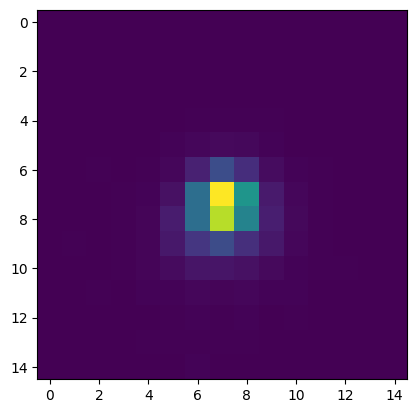

In [79]:
plt.imshow(psf_yx)

In [80]:
def gauss_2d(amp, bg, mu_x, mu_y, cxx, cxy, cyy):
    def fun(coords):
        cov_inv = np.linalg.inv(np.array([[cxx, cxy], [cxy, cyy]]))
        exponent = -0.5 * (cov_inv[0,0] * (coords[:, 1] - mu_x) ** 2
                           + 2 * cov_inv[0, 1] * (coords[:, 1] - mu_x) * (coords[:, 0] - mu_y)
                           + cov_inv[1, 1] * (coords[:, 0] - mu_y) ** 2
            )
        
        return amp * np.exp(exponent) + bg
    return fun

In [81]:
def show_2d_fit(psf, fit):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(psf)
    plt.subplot(1,2,2)
    plt.imshow(fit)
    plt.show()

### Curve fit

In [82]:
from scipy.optimize import curve_fit

In [83]:
def eval_fun(x, amp, bg, mu_x, mu_y, cxx, cxy, cyy):
    return gauss_2d(amp=amp, bg=bg, mu_x=mu_x, mu_y=mu_y, cxx=cxx, cxy=cxy, cyy=cyy)(x)

In [84]:
bg = np.median(psf_yx)
amp = psf_yx.max() - bg

In [85]:
params = [
        amp, 
        bg, 
        mu_x, 
        mu_y, 
        (kld_fwhm_x/(2 * np.sqrt(2 * np.log(2))))**2,
        0,
        (kld_fwhm_y/(2 * np.sqrt(2 * np.log(2))))**2
    ]

In [86]:
popt, pcov = curve_fit(
    eval_fun,
    coords_yx,
    psf_yx.ravel(),
    p0=params,
)

In [87]:
popt

array([ 9832.89792887,   133.71391082,  1155.20436166,  1216.22221404,
       17151.50755758, -1030.58369714, 19886.2384395 ])

In [88]:
from copy import copy
cv_2d_params = copy(popt)

In [89]:
cv_2d = gauss_2d(*popt)(fine_coords_yx)
cv_2d = cv_2d.reshape((500, 500))

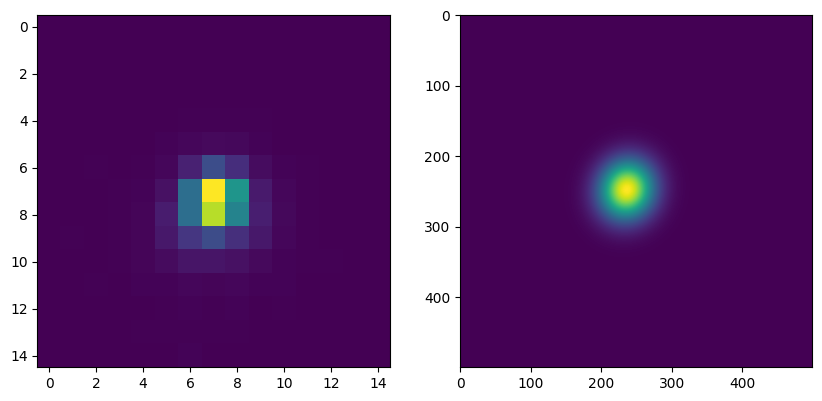

In [90]:
show_2d_fit(psf_yx, cv_2d)

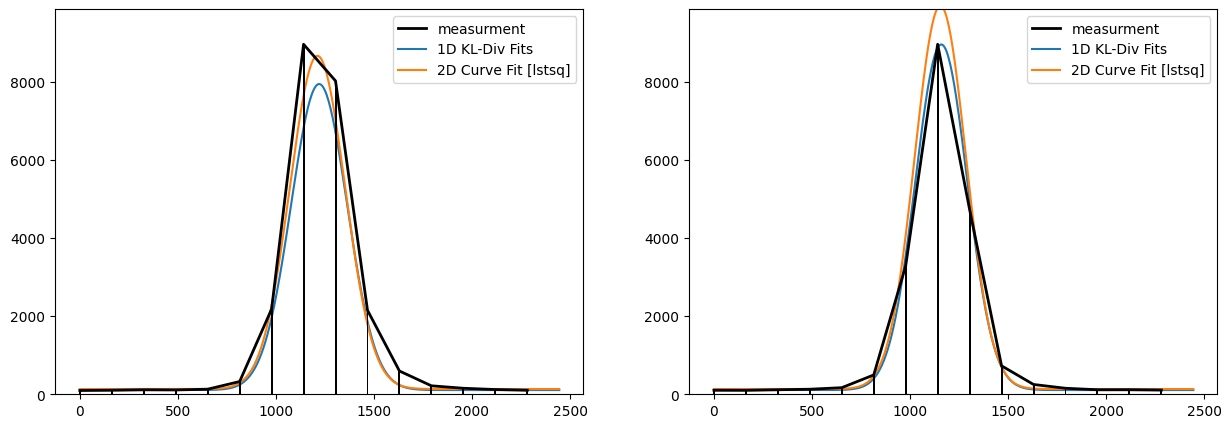

In [91]:
center = np.array(psf_yx.shape)//2
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(coords_y, psf_yx[:, center[1]], '-', label='measurment', color='k', linewidth=2, zorder=10)
plt.bar(coords_y, psf_yx[:, center[1]], color='k', zorder=10, width=10)
plt.plot(fine_coords_y[:,0], gauss_2d(*params)(fine_coords_y), label="1D KL-Div Fits")
plt.plot(fine_coords_y[:,0], gauss_2d(*popt)(fine_coords_y), label="2D Curve Fit [lstsq]")
plt.ylim(y_lim);
plt.legend();
plt.subplot(1,2,2)
plt.plot(coords_x, psf_yx[center[0]], '-', label='measurment', color='k', linewidth=2, zorder=10)
plt.bar(coords_x, psf_yx[center[0]], color='k', zorder=10, width=10)
plt.plot(fine_coords_x[:,1], gauss_2d(*params)(fine_coords_x), label="1D KL-Div Fits")
plt.plot(fine_coords_x[:,1], gauss_2d(*popt)(fine_coords_x), label="2D Curve Fit [lstsq]")
plt.ylim(y_lim);
plt.legend()

### Minimize KL-Div

In [92]:
from scipy.special import kl_div
from scipy.optimize import minimize

def get_objective(coords, measurement):
    def objective(params):

        
        fit = gauss_2d(*params)(coords)
        
        kld = kl_div(fit, measurement)
        kld[np.isinf(kld)] = 0
        
        return np.sum(kld)
    
    return objective

In [93]:
res = minimize(get_objective(coords_yx, psf_yx.ravel()), 
               x0=params,
               method='L-BFGS-B',
               options={'disp': True},
               bounds=[
                   (params[0]*0.5, params[0]*1.5), 
                   (0, params[0]/2), 
                   (params[2] - spacing[2], params[2] + spacing[2]), 
                   (params[3] - spacing[1], params[3] + spacing[1]), 
                   (params[4]*0.5, params[4]*1.5),
                   (None, None),
                   (params[6]*0.5, params[6]*1.5),
               ]
              )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


At iterate    0    f=  2.29355D+03    |proj g|=  2.45568D+01

At iterate    1    f=  2.17945D+03    |proj g|=  1.61935D+01

At iterate    2    f=  2.08172D+03    |proj g|=  7.87305D-01

At iterate    3    f=  2.08134D+03    |proj g|=  4.54802D-01

At iterate    4    f=  2.08106D+03    |proj g|=  4.54165D-01

At iterate    5    f=  2.07980D+03    |proj g|=  1.36661D+00

At iterate    6    f=  2.07706D+03    |proj g|=  2.71789D+00

At iterate    7    f=  2.06952D+03    |proj g|=  4.99181D+00

At iterate    8    f=  2.05137D+03    |proj g|=  8.24444D+00

At iterate    9    f=  2.00995D+03    |proj g|=  1.23629D+01

At iterate   10    f=  1.93383D+03    |proj g|=  1.54472D+01

At iterate   11    f=  1.83959D+03    |proj g|=  1.34111D+01

At iterate   12    f=  1.82173D+03    |proj g|=  1.25071D+01

At iterate   13    f=  1.77587D+03    |proj g|=  4.41812D+00

At iterate   14    f=  1.76935D+03    |proj g|=  4.82351D-01

At iterate   15    f=  1.76900D+03    |proj g|=  8.58721D-02

At itera

In [94]:
res.x

array([ 8478.68137616,   116.67565542,  1153.35317619,  1230.49903611,
       21401.39385203, -1576.44704333, 23911.3349062 ])

In [95]:
kl_2d_params = copy(res.x)

In [96]:
kl_2d = gauss_2d(*res.x)(fine_coords_yx)
kl_2d = kl_2d.reshape((500, 500))

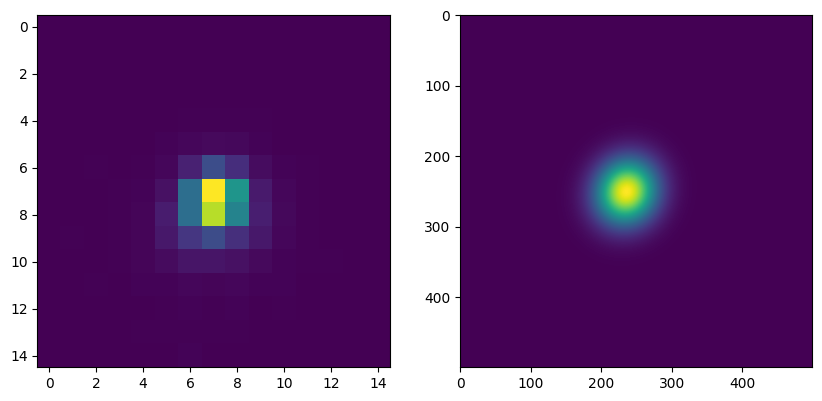

In [97]:
show_2d_fit(psf_yx, kl_2d)

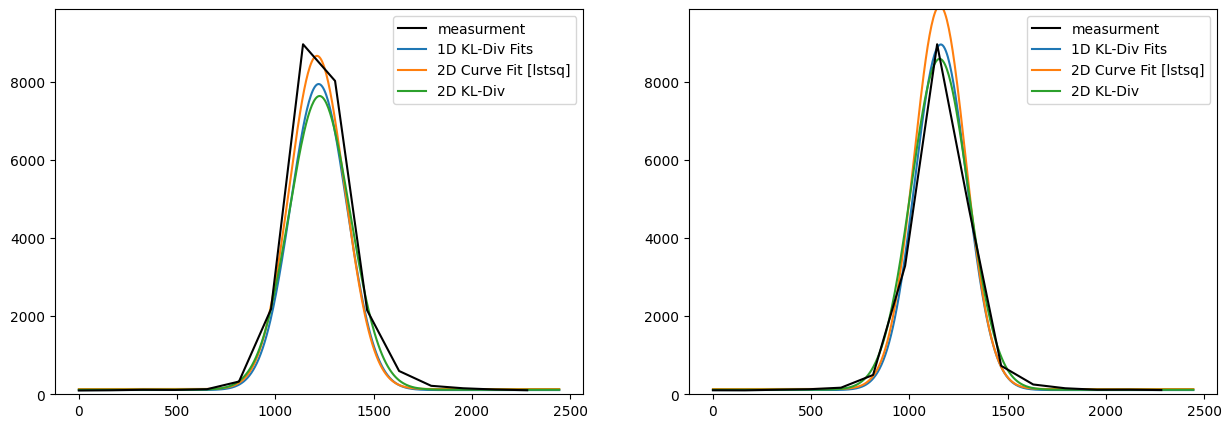

In [98]:
center = np.array(psf_yx.shape)//2
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(coords_y, psf_yx[:, center[1]], '-', label='measurment', color='k', zorder=10)
# plt.bar(coords_y, psf_yx[:, center[1]], color='k', zorder=10, width=5)
plt.plot(fine_coords_y[:,0], gauss_2d(*params)(fine_coords_y), label="1D KL-Div Fits")
plt.plot(fine_coords_y[:,0], gauss_2d(*popt)(fine_coords_y), label="2D Curve Fit [lstsq]")
plt.plot(fine_coords_y[:,0], gauss_2d(*res.x)(fine_coords_y), label="2D KL-Div")
plt.ylim(y_lim);
plt.legend();
plt.subplot(1,2,2)
plt.plot(coords_x, psf_yx[center[0]], '-', label='measurment', color='k', zorder=10)
# plt.bar(coords_x, psf_yx[center[0]], color='k', zorder=10, width=5)
plt.plot(fine_coords_x[:,1], gauss_2d(*params)(fine_coords_x), label="1D KL-Div Fits")
plt.plot(fine_coords_x[:,1], gauss_2d(*popt)(fine_coords_x), label="2D Curve Fit [lstsq]")
plt.plot(fine_coords_x[:,1], gauss_2d(*res.x)(fine_coords_x), label="2D KL-Div")
plt.ylim(y_lim);
plt.legend();

In [99]:
from skimage.measure import find_contours

In [100]:
cc = find_contours(gauss_2d(*params)(fine_coords_yx).reshape(500, 500), level=amp/2 + bg)[0]
cc = cc / 500 * psf_yx.shape[0]

In [101]:
cv_cc = find_contours(cv_2d, level=popt[0]/2 + popt[1])[0]
cv_cc = cv_cc / 500 * psf_yx.shape[0]

In [102]:
kl_cc = find_contours(kl_2d, level=res.x[0]/2 + res.x[1])[0]
kl_cc = kl_cc / 500 * psf_yx.shape[0]

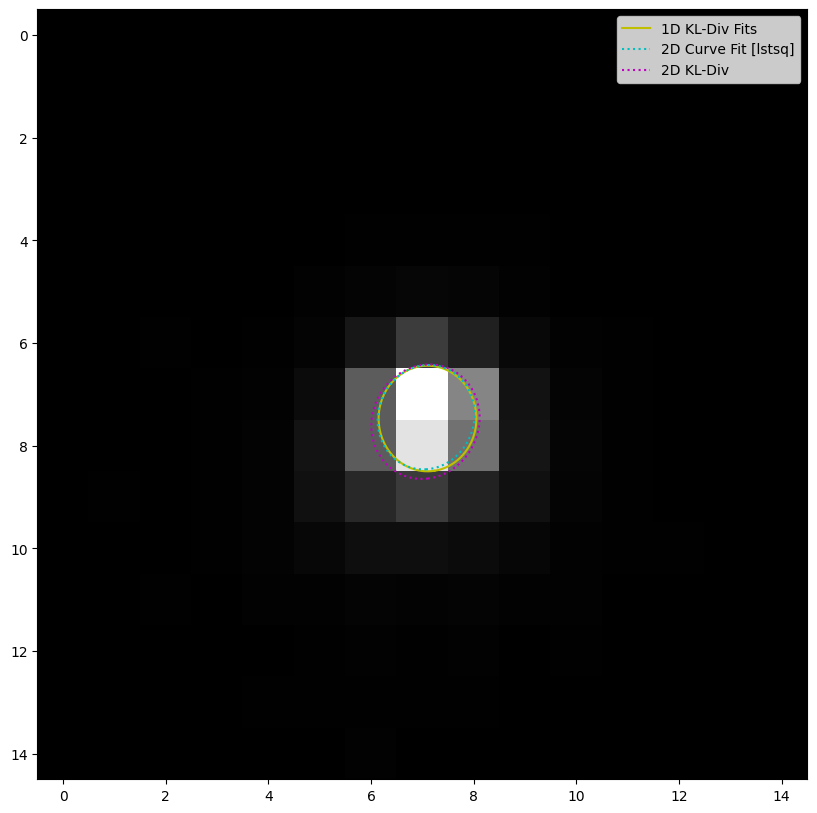

In [103]:
plt.figure(figsize=(10,10))
plt.imshow(psf_yx, cmap='gray')
plt.plot(cc[:,1], cc[:,0], '-', color='y', label="1D KL-Div Fits")
plt.plot(cv_cc[:,1], cv_cc[:,0], ':', color='c', label="2D Curve Fit [lstsq]")
plt.plot(kl_cc[:,1], kl_cc[:,0], ':', color='m', label="2D KL-Div")
plt.legend()

In [104]:
cv_2d_fwhm_x = fwhm(np.sqrt(popt[4]))
cv_2d_fwhm_y = fwhm(np.sqrt(popt[6]))

In [105]:
kld_2d_fwhm_x = fwhm(np.sqrt(res.x[4]))
kld_2d_fwhm_y = fwhm(np.sqrt(res.x[6]))

In [106]:
print("FWHM X")
print(f"Est. 1D: {est_fwhm_x:4.4f}, {est_fwhm_x/spacing[2]:4.4f}")
print(f"CV.  1D:  {cv_fwhm_x:4.4f}, {cv_fwhm_x/spacing[2]:4.4f}")
print(f"CV.  2D:  {cv_2d_fwhm_x:4.4f}, {cv_2d_fwhm_x/spacing[2]:4.4f}")
print(f"KLD. 1D:  {kld_fwhm_x:4.4f}, {kld_fwhm_x/spacing[2]:4.4f}")
print(f"KLD. 2D:  {kld_2d_fwhm_x:4.4f}, {kld_2d_fwhm_x/spacing[2]:4.4f}")

FWHM X
Est. 1D: 318.9650, 1.9568
CV.  1D:  297.9680, 1.8280
CV.  2D:  308.3961, 1.8920
KLD. 1D:  311.0512, 1.9083
KLD. 2D:  344.4917, 2.1134


In [107]:
print("FWHM Y")
print(f"Est. 1D: {est_fwhm_y:4.4f}, {est_fwhm_y/spacing[1]:4.4f}")
print(f"CV.  1D:  {cv_fwhm_y:4.4f}, {cv_fwhm_y/spacing[1]:4.4f}")
print(f"CV.  2D:  {cv_2d_fwhm_y:4.4f}, {cv_2d_fwhm_y/spacing[1]:4.4f}")
print(f"KLD. 1D:  {kld_fwhm_y:4.4f}, {kld_fwhm_y/spacing[1]:4.4f}")
print(f"KLD. 2D:  {kld_2d_fwhm_y:4.4f}, {kld_2d_fwhm_y/spacing[1]:4.4f}")

FWHM Y
Est. 1D: 350.5216, 2.1504
CV.  1D:  320.9622, 1.9691
CV.  2D:  332.0734, 2.0373
KLD. 1D:  335.9849, 2.0613
KLD. 2D:  364.1327, 2.2339


# 3D

In [108]:
zz = np.arange(psf.shape[0]) * spacing[0]
yy = np.arange(psf.shape[1]) * spacing[1]
xx = np.arange(psf.shape[2]) * spacing[2]
z, y, x = np.meshgrid(zz, yy, xx, indexing="ij")
coords_zyx = np.stack([z.ravel(), y.ravel(), x.ravel()], -1)

In [109]:
zz_fine = np.linspace(0, psf.shape[0], 500) * spacing[0]
yy_fine = np.linspace(0, psf.shape[1], 500) * spacing[1]
xx_fine = np.linspace(0, psf.shape[2], 500) * spacing[2]
z_fine, y_fine, x_fine = np.meshgrid(zz_fine, yy_fine, xx_fine, indexing="ij")
fine_coords_zyx = np.stack([z_fine.ravel(), y_fine.ravel(), x_fine.ravel()], -1)

# fine_coords_y = np.stack([yy_fine, [xx_fine[xx_fine.shape[0]//2],]*len(yy_fine)], axis=1)
# fine_coords_x = np.stack([[yy_fine[yy_fine.shape[0]//2],]*len(xx_fine), xx_fine], axis=1)

In [110]:
def gauss_3d(amp, bg, mu_x, mu_y, mu_z, cxx, cxy, cxz, cyy, cyz, czz):
    def fun(coords):
        cov_inv = np.linalg.inv(np.array([[cxx, cxy, cxz], [cxy, cyy, cyz], [cxz, cyz, czz]]))
        exponent = -0.5 * (
                    cov_inv[0, 0] * (coords[:, 2] - mu_x) ** 2
                    + 2 * cov_inv[0, 1] * (coords[:, 2] - mu_x) * (coords[:, 1] - mu_y)
                    + 2 * cov_inv[0, 2] * (coords[:, 2] - mu_x) * (coords[:, 0] - mu_z)
                    + cov_inv[1, 1] * (coords[:, 1] - mu_y) ** 2
                    + 2 * cov_inv[1, 2] * (coords[:, 1] - mu_y) * (coords[:, 0] - mu_z)
                    + cov_inv[2, 2] * (coords[:, 0] - mu_z) ** 2
                )
        
        return amp * np.exp(exponent) + bg
    return fun

### Curve fit

In [111]:
from scipy.optimize import curve_fit

In [112]:
def eval_fun(x, amp, bg, mu_x, mu_y, mu_z, cxx, cxy, cxz, cyy, cyz, czz):
    return gauss_3d(amp=amp, bg=bg, mu_x=mu_x, mu_y=mu_y, mu_z=mu_z, 
                    cxx=cxx, cxy=cxy, cxz=cxz, cyy=cyy, cyz=cyz, czz=czz)(x)

In [113]:
bg = np.median(psf)
amp = psf.max() - bg

In [114]:
params = [
        amp, 
        bg, 
        mu_x, 
        mu_y, 
        mu_z,
        (kld_fwhm_x/(2 * np.sqrt(2 * np.log(2))))**2,
        0,
        0,
        (kld_fwhm_y/(2 * np.sqrt(2 * np.log(2))))**2,
        0,
        (kld_fwhm_z/(2 * np.sqrt(2 * np.log(2))))**2,
    ]

In [115]:
popt, pcov = curve_fit(
    eval_fun,
    coords_zyx,
    psf.ravel(),
    p0=params,
)

In [116]:
popt

array([ 8.20516949e+03,  1.58351379e+02,  1.15308783e+03,  1.19380988e+03,
        1.00728954e+03,  2.31253063e+04, -6.63105296e+02, -3.91654216e+03,
        2.66979021e+04, -1.85491843e+02,  2.20528946e+05])

In [117]:
cv_3d = gauss_3d(*popt)(fine_coords_zyx)
cv_3d = cv_3d.reshape((500, 500, 500))

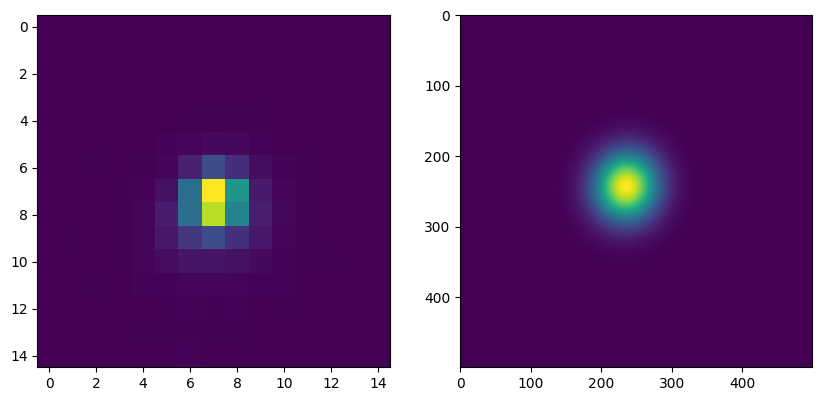

In [118]:
show_2d_fit(psf[psf.shape[0]//2], cv_3d[cv_3d.shape[0]//2])

### Minimize KL-Div

In [119]:
from scipy.special import kl_div
from scipy.optimize import minimize

def get_objective(coords, measurement):
    def objective(params):

        
        fit = gauss_3d(*params)(coords)
        
        kld = kl_div(fit, measurement)
        kld[np.isinf(kld)] = 0
        
        return np.sum(kld)
    
    return objective

In [120]:
params

[8852.0,
 111.0,
 1159.6756268606334,
 1220.399506600485,
 1030.5898572338867,
 17448.1036420622,
 0,
 0,
 20357.482778882466,
 0,
 164119.27688160297]

In [121]:
res = minimize(get_objective(coords_zyx, psf.ravel()), 
               x0=params,
               method='L-BFGS-B',
               options={'disp': True},
               bounds=[
                   (params[0]*0.5, params[0]*1.5), 
                   (0, params[0]/2), 
                   (params[2] - spacing[2], params[2] + spacing[2]), 
                   (params[3] - spacing[1], params[3] + spacing[1]), 
                   (params[4] - spacing[0], params[4] + spacing[0]), 
                   (params[5]*0.5, params[5]*1.5),
                   (None, None),
                   (None, None),
                   (params[8]*0.5, params[8]*1.5),
                   (None, None),
                   (params[10]*0.5, params[10]*1.5),
               ]
              )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.99341D+04    |proj g|=  5.54067D+02

At iterate    1    f=  8.73325D+04    |proj g|=  4.54708D+02

At iterate    2    f=  8.08541D+04    |proj g|=  6.18608D+01

At iterate    3    f=  8.05716D+04    |proj g|=  3.46194D+01

At iterate    4    f=  8.04513D+04    |proj g|=  1.45635D+01

At iterate    5    f=  8.04188D+04    |proj g|=  8.00509D+00

At iterate    6    f=  8.03923D+04    |proj g|=  7.89013D+00

At iterate    7    f=  8.03546D+04    |proj g|=  1.32160D+01

At iterate    8    f=  8.03122D+04    |proj g|=  6.92678D+00

At iterate    9    f=  8.02722D+04    |proj g|=  6.32571D+00

At iterate   10    f=  8.02088D+04    |proj g|=  1.05561D+01

At iterate   11    f=  8.00839D+04    |proj g|=  2.39614D+01

At iterate   12    f=  7.97516D+04    |proj g|=  4.91927D+01

At iterate   13    f=  7.9


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [122]:
res.x

array([ 7.38243853e+03,  1.29671177e+02,  1.15235734e+03,  1.20483958e+03,
        1.01692619e+03,  2.61721555e+04, -8.28845528e+02, -5.06542057e+02,
        3.05362242e+04,  7.07278171e+01,  2.46178915e+05])

In [123]:
kl_3d = gauss_3d(*res.x)(fine_coords_zyx)
kl_3d = kl_3d.reshape((500, 500, 500))

In [124]:
cv_3d_fwhm_x = fwhm(np.sqrt(popt[5]))
cv_3d_fwhm_y = fwhm(np.sqrt(popt[8]))
cv_3d_fwhm_z = fwhm(np.sqrt(popt[10]))

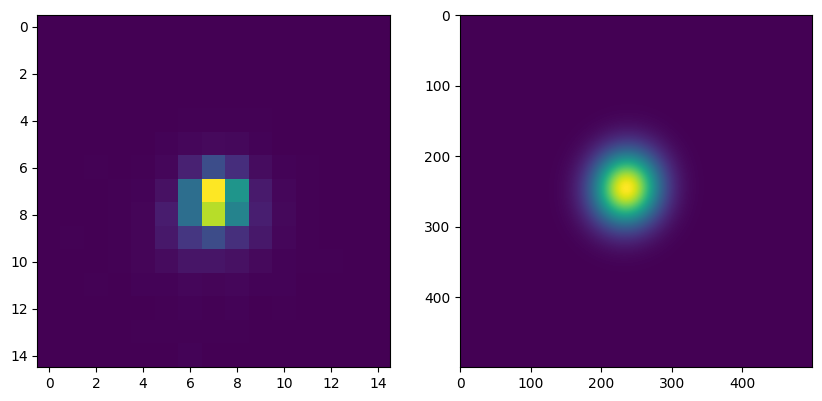

In [125]:
show_2d_fit(psf[psf.shape[0]//2], kl_3d[kl_3d.shape[0]//2])

In [126]:
kld_3d_fwhm_x = fwhm(np.sqrt(res.x[5]))
kld_3d_fwhm_y = fwhm(np.sqrt(res.x[8]))
kld_3d_fwhm_z = fwhm(np.sqrt(res.x[10]))

In [127]:
from skimage.measure import find_contours

In [128]:
zz_fine = np.linspace(0, psf.shape[0], 500) * spacing[0]
yy_fine = np.linspace(0, psf.shape[1], 500) * spacing[1]
xx_fine = np.linspace(0, psf.shape[2], 500) * spacing[2]
z_fine, y_fine, x_fine = np.meshgrid(zz_fine, yy_fine, xx_fine, indexing="ij")
fine_coords_zyx = np.stack([z_fine.ravel(), y_fine.ravel(), x_fine.ravel()], -1)

In [129]:
fc_z_plane = np.stack([
    (np.ones((1, 500, 500)) * psf.shape[0]//2 * spacing[0]).ravel(),
    y_fine[:1].ravel(),
    x_fine[:1].ravel()
],
-1
)

In [130]:
fc_y_plane = np.stack([
    z_fine[:, :1].ravel(),
    (np.ones((500, 1, 500)) * psf.shape[1]//2 * spacing[1]).ravel(),
    x_fine[:, :1].ravel()
],
-1
)

In [131]:
fc_x_plane = np.stack([
    z_fine[:, :, :1].ravel(),
    y_fine[:, :, :1].ravel(),
    (np.ones((500, 500, 1)) * psf.shape[1]//2 * spacing[2]).ravel(),
],
-1
)

In [132]:
base_z_plane = gauss_3d(*params)(fc_z_plane).reshape(500, 500)
cv_z_plane = gauss_3d(*popt)(fc_z_plane).reshape(500, 500)
kl_z_plane = gauss_3d(*res.x)(fc_z_plane).reshape(500, 500)

In [133]:
base_y_plane = gauss_3d(*params)(fc_y_plane).reshape(500, 500)
cv_y_plane = gauss_3d(*popt)(fc_y_plane).reshape(500, 500)
kl_y_plane = gauss_3d(*res.x)(fc_y_plane).reshape(500, 500)

In [134]:
base_x_plane = gauss_3d(*params)(fc_x_plane).reshape(500, 500)
cv_x_plane = gauss_3d(*popt)(fc_x_plane).reshape(500, 500)
kl_x_plane = gauss_3d(*res.x)(fc_x_plane).reshape(500, 500)

In [135]:
cv2d_z_plane = gauss_2d(*cv_2d_params)(fine_coords_yx).reshape(500, 500)

In [136]:
kl2d_z_plane = gauss_2d(*kl_2d_params)(fine_coords_yx).reshape(500, 500)

In [137]:
base_z_contours = find_contours(base_z_plane, level=params[0]/2 + params[1])[0]
base_z_contours = base_z_contours / 500 * psf.shape[1]

In [138]:
cv2d_z_convtours = find_contours(cv2d_z_plane, level=cv_2d_params[0]/2 + cv_2d_params[1])[0]
cv2d_z_convtours = cv2d_z_convtours / 500 * psf.shape[1]

In [139]:
kl2d_z_convtours = find_contours(kl2d_z_plane, level=kl_2d_params[0]/2 + kl_2d_params[1])[0]
kl2d_z_convtours = kl2d_z_convtours / 500 * psf.shape[1]

In [140]:
base_y_contours = find_contours(base_y_plane, level=params[0]/2 + params[1])[0]
base_y_contours = base_y_contours / 500 * psf.shape[1]

In [141]:
base_x_contours = find_contours(base_x_plane, level=params[0]/2 + params[1])[0]
base_x_contours = base_x_contours / 500 * psf.shape[1]

In [142]:
cv_z_contours = find_contours(cv_z_plane, level=popt[0]/2 + popt[1])[0]
cv_z_contours = cv_z_contours / 500 * psf.shape[1]

In [143]:
cv_y_contours = find_contours(cv_y_plane, level=popt[0]/2 + popt[1])[0]
cv_y_contours = cv_y_contours / 500 * psf.shape[1]

In [144]:
cv_x_contours = find_contours(cv_x_plane, level=popt[0]/2 + popt[1])[0]
cv_x_contours = cv_x_contours / 500 * psf.shape[1]

In [145]:
kl_z_contours = find_contours(kl_z_plane, level=res.x[0]/2 + res.x[1])[0]
kl_z_contours = kl_z_contours / 500 * psf.shape[1]

In [146]:
kl_y_contours = find_contours(kl_y_plane, level=res.x[0]/2 + res.x[1])[0]
kl_y_contours = kl_y_contours / 500 * psf.shape[1]

In [147]:
kl_x_contours = find_contours(kl_x_plane, level=res.x[0]/2 + res.x[1])[0]
kl_x_contours = kl_x_contours / 500 * psf.shape[1]

In [148]:
from matplotlib_scalebar.scalebar import ScaleBar
def get_ellipsoid(cov, scale=spacing[1]):
    bias=0
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)

    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    x, y, z = (cov @ np.stack((x, y, z), 0).reshape(3, -1) + bias).reshape(3, *x.shape)
    return x/scale, y/scale, z/scale

In [149]:
xy_spacing = spacing[1]
z_spacing = spacing[0]

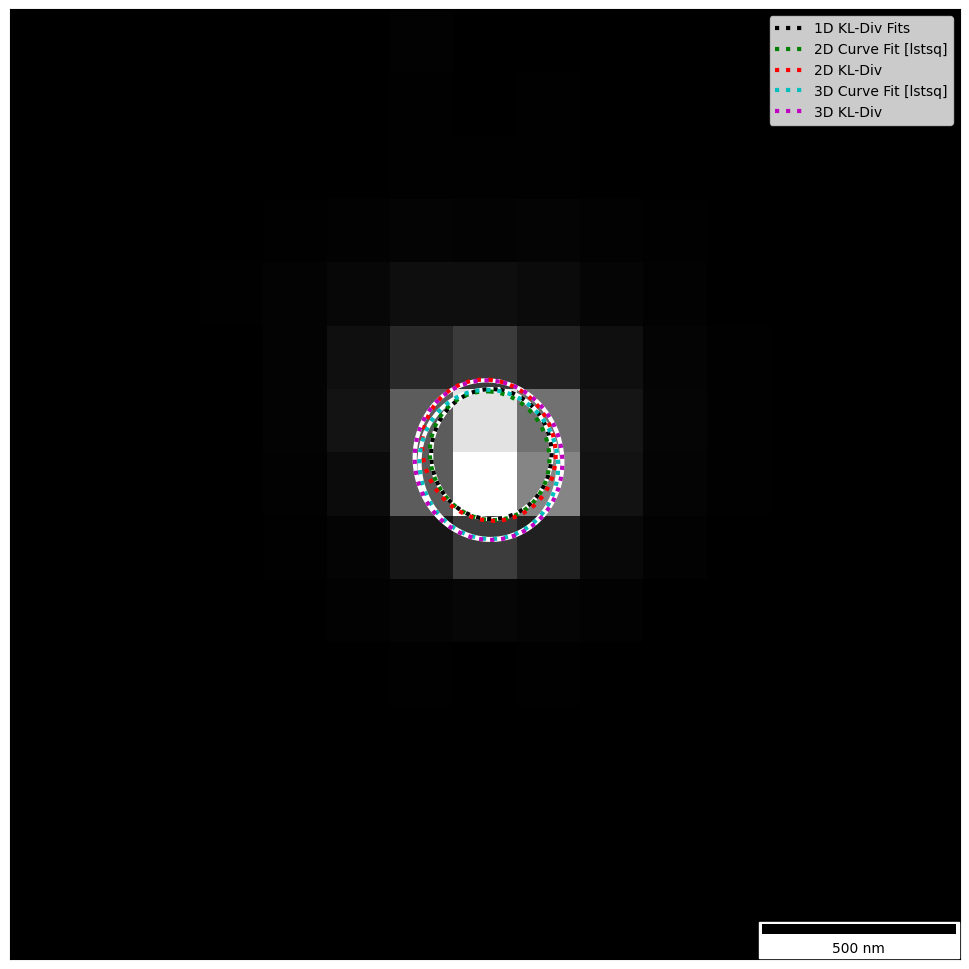

In [150]:
vmin, vmax = np.quantile(psf, 0.03), np.quantile(psf, 1)

extent = [0, psf.shape[1], 0, psf.shape[2]]
fig = plt.figure(figsize=(10,10))

ax_xy = fig.add_axes([0.025, 0.025, 0.95, 0.95])

scalebar = ScaleBar(xy_spacing, "nm", fixed_value=500, location="lower " "right")
ax_xy.add_artist(scalebar)
ax_xy.set_xticks([])
ax_xy.set_yticks([])
ax_xy.imshow(
    psf[psf.shape[0]//2],
    cmap='gray',
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           '-', color='white', linewidth=3)
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           ':', color='black', linewidth=3, label="1D KL-Div Fits")
ax_xy.plot(cv2d_z_convtours[:,1] + 0.5, cv2d_z_convtours[:,0] + 0.5, 
           ':', color='green', linewidth=3, label="2D Curve Fit [lstsq]")
ax_xy.plot(kl2d_z_convtours[:,1] + 0.5, kl2d_z_convtours[:,0] + 0.5, 
           ':', color='red', linewidth=3, label="2D KL-Div")
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           ':', color='c', linewidth=3, label="3D Curve Fit [lstsq]")
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           ':', color='m', linewidth=3, label="3D KL-Div")
ax_xy.legend()

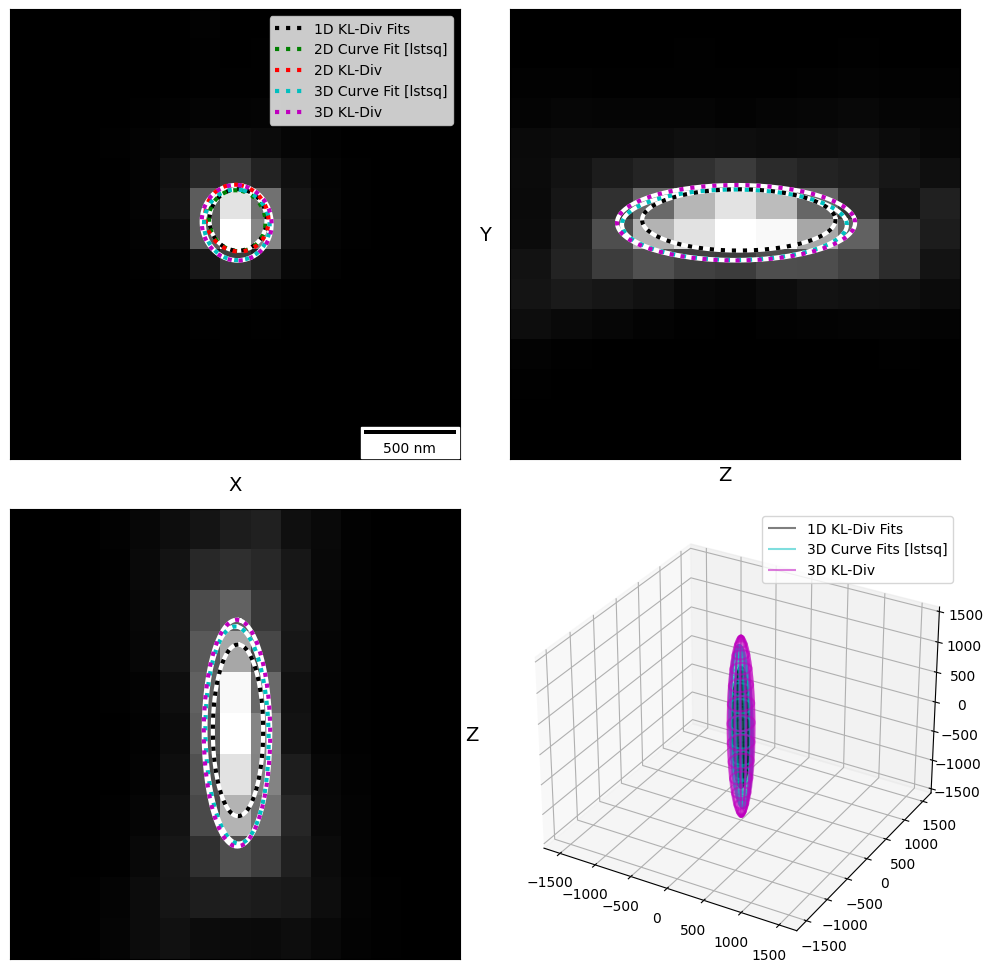

In [151]:
vmin, vmax = np.quantile(psf, 0.03), np.quantile(psf, 1)

extent = [0, psf.shape[1], 0, psf.shape[2]]

fig = plt.figure(figsize=(10, 10))

ax_xy = fig.add_axes([0.025, 0.525, 0.45, 0.45])
ax_yz = fig.add_axes([0.525, 0.525, 0.45, 0.45])
ax_zx = fig.add_axes([0.025, 0.025, 0.45, 0.45])

ax_X = fig.add_axes([0.24, 0.49, 0.02, 0.02])
ax_X.text(0.5, 0.5, "X", fontsize=14, ha="center", va="center")
ax_X.axis("off")
ax_Y = fig.add_axes([0.49, 0.74, 0.02, 0.02])
ax_Y.text(0.5, 0.5, "Y", fontsize=14, ha="center", va="center")
ax_Y.axis("off")
ax_Z = fig.add_axes([0.477, 0.24, 0.02, 0.02])
ax_Z.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
ax_Z.axis("off")
ax_Z1 = fig.add_axes([0.73, 0.50, 0.02, 0.02])
ax_Z1.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
ax_Z1.axis("off")

scalebar = ScaleBar(xy_spacing, "nm", fixed_value=500, location="lower " "right")
ax_xy.add_artist(scalebar)
ax_xy.set_xticks([])
ax_xy.set_yticks([])
ax_xy.imshow(
    psf[psf.shape[0]//2],
    cmap='gray',
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           '-', color='white', linewidth=3)
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           ':', color='black', linewidth=3, label="1D KL-Div Fits")
ax_xy.plot(cv2d_z_convtours[:,1] + 0.5, cv2d_z_convtours[:,0] + 0.5, 
           ':', color='green', linewidth=3, label="2D Curve Fit [lstsq]")
ax_xy.plot(kl2d_z_convtours[:,1] + 0.5, kl2d_z_convtours[:,0] + 0.5, 
           ':', color='red', linewidth=3, label="2D KL-Div")
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           ':', color='c', linewidth=3, label="3D Curve Fit [lstsq]")
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           ':', color='m', linewidth=3, label="3D KL-Div")
ax_xy.legend()

ax_zx.set_xticks([])
ax_zx.set_yticks([])
ax_zx.imshow(
    psf[:, psf.shape[1]//2],
    cmap='gray',
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_zx.plot(base_y_contours[:,1] + 0.5, base_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           '-', color='white', linewidth=3)
ax_zx.plot(cv_y_contours[:,1] + 0.5, cv_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           '-', color='white', linewidth=3)
ax_zx.plot(kl_y_contours[:,1] + 0.5, kl_y_contours[:,0] + 0.5 * spacing[0]/spacing[1], 
           '-', color='white', linewidth=3)
ax_zx.plot(base_y_contours[:,1] + 0.5, base_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           ':', color='black', linewidth=3)
ax_zx.plot(cv_y_contours[:,1] + 0.5, cv_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           ':', color='c', linewidth=3)
ax_zx.plot(kl_y_contours[:,1] + 0.5, kl_y_contours[:,0] + 0.5 * spacing[0]/spacing[1], 
           ':', color='m', linewidth=3)

ax_yz.set_xticks([])
ax_yz.set_yticks([])
ax_yz.imshow(
    psf[:, :, psf.shape[2]//2].T,
    cmap='gray',
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_yz.plot(base_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], base_x_contours[:,1] + 0.5, 
           '-', color='white', linewidth=3)
ax_yz.plot(cv_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], cv_x_contours[:,1] + 0.5,
           '-', color='white', linewidth=3)
ax_yz.plot(kl_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], kl_x_contours[:,1] + 0.5, 
           '-', color='white', linewidth=3)
ax_yz.plot(base_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], base_x_contours[:,1] + 0.5, 
           ':', color='black', linewidth=3)
ax_yz.plot(cv_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], cv_x_contours[:,1] + 0.5,
           ':', color='c', linewidth=3)
ax_yz.plot(kl_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], kl_x_contours[:,1] + 0.5, 
           ':', color='m', linewidth=3)


ax_3D = fig.add_axes(
        [0.525, 0.025, 0.45, 0.45], projection="3d", computed_zorder=True
    )

base_ell = get_ellipsoid([[params[5], 0, 0], [0, params[8], 0], [0, 0, params[10]]], spacing[1])
ax_3D.plot_surface(*base_ell, rstride=2, cstride=2, color='black', antialiased=True,
               alpha=0.5)
ax_3D.plot_wireframe(*base_ell, rstride=2, cstride=2, color='black', antialiased=True,
               alpha=0.5, label="1D KL-Div Fits")

cv_ell = get_ellipsoid([[popt[5], popt[6], popt[7]], [popt[6], popt[8], popt[9]], [popt[7], popt[9], popt[10]]], spacing[1])
ax_3D.plot_surface(*cv_ell, rstride=1, cstride=1, color='c', antialiased=True,
               alpha=0.25)
ax_3D.plot_wireframe(*cv_ell, rstride=2, cstride=2, color='c', antialiased=True,
               alpha=0.5, label="3D Curve Fits [lstsq]")

kl_ell = get_ellipsoid([[res.x[5], res.x[6], res.x[7]], [res.x[6], res.x[8], res.x[9]], [res.x[7], res.x[9], res.x[10]]], spacing[1])
ax_3D.plot_wireframe(*kl_ell, rstride=2, cstride=2, color='m', antialiased=True,
               alpha=0.5, label="3D KL-Div")


bbox_min = np.min([*kl_ell])
bbox_max = np.max([*kl_ell])
ax_3D.auto_scale_xyz([bbox_min, bbox_max], [bbox_min, bbox_max], [bbox_min, bbox_max])
ax_3D.legend()

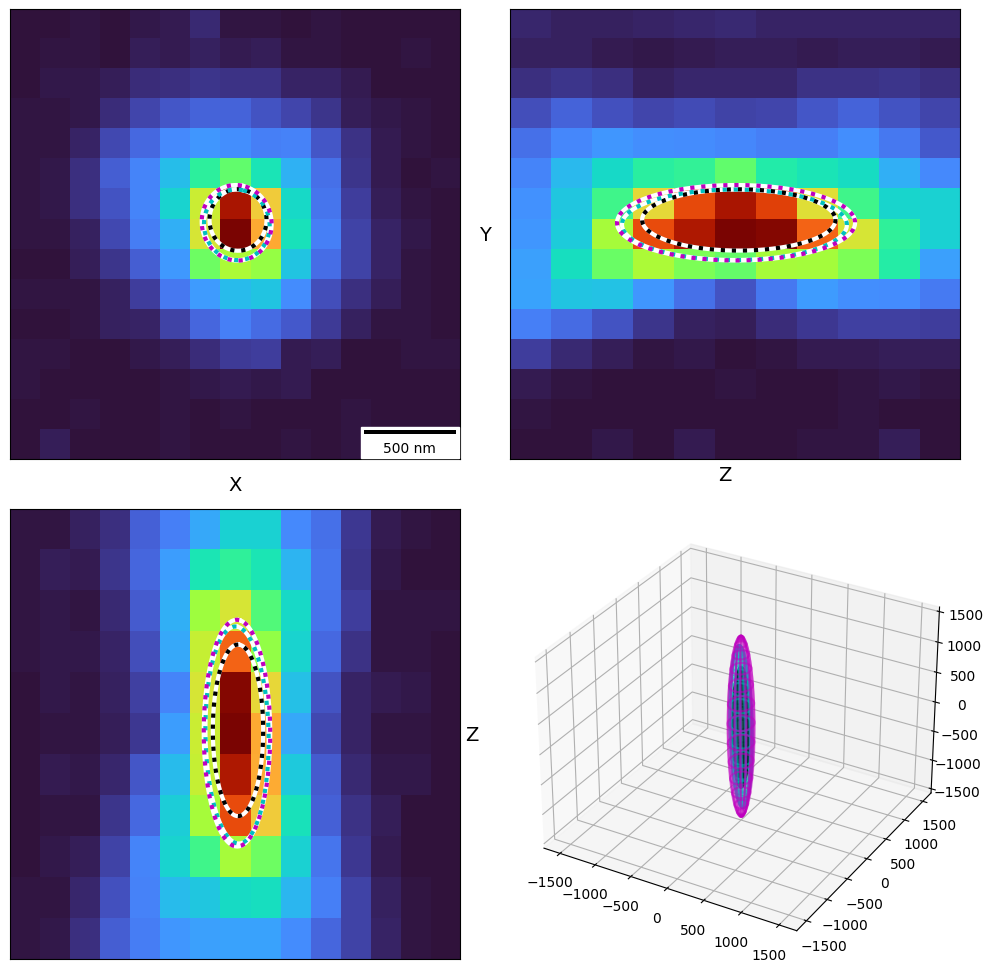

In [152]:
vmin, vmax = np.quantile(np.sqrt(np.max(psf, axis=0)), 0.03), np.quantile(np.sqrt(np.max(psf, axis=0)), 1)

fig = plt.figure(figsize=(10, 10))

ax_xy = fig.add_axes([0.025, 0.525, 0.45, 0.45])
ax_yz = fig.add_axes([0.525, 0.525, 0.45, 0.45])
ax_zx = fig.add_axes([0.025, 0.025, 0.45, 0.45])

ax_X = fig.add_axes([0.24, 0.49, 0.02, 0.02])
ax_X.text(0.5, 0.5, "X", fontsize=14, ha="center", va="center")
ax_X.axis("off")
ax_Y = fig.add_axes([0.49, 0.74, 0.02, 0.02])
ax_Y.text(0.5, 0.5, "Y", fontsize=14, ha="center", va="center")
ax_Y.axis("off")
ax_Z = fig.add_axes([0.477, 0.24, 0.02, 0.02])
ax_Z.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
ax_Z.axis("off")
ax_Z1 = fig.add_axes([0.73, 0.50, 0.02, 0.02])
ax_Z1.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
ax_Z1.axis("off")


scalebar = ScaleBar(xy_spacing, "nm", fixed_value=500, location="lower " "right")
ax_xy.add_artist(scalebar)
ax_xy.set_xticks([])
ax_xy.set_yticks([])
ax_xy.imshow(
    np.sqrt(np.max(psf, axis=0)),
    cmap="turbo",
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           '-', color='white', linewidth=3)
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           '-', color='white', linewidth=3)
ax_xy.plot(base_z_contours[:,1] + 0.5, base_z_contours[:,0] + 0.5, 
           ':', color='black', linewidth=3)
ax_xy.plot(cv_z_contours[:,1] + 0.5, cv_z_contours[:,0] + 0.5,
           ':', color='c', linewidth=3)
ax_xy.plot(kl_z_contours[:,1] + 0.5, kl_z_contours[:,0] + 0.5,
           ':', color='m', linewidth=3)

ax_zx.set_xticks([])
ax_zx.set_yticks([])
ax_zx.imshow(
    np.sqrt(np.max(psf, axis=1)),
    cmap="turbo",
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_zx.plot(base_y_contours[:,1] + 0.5, base_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           '-', color='white', linewidth=3)
ax_zx.plot(cv_y_contours[:,1] + 0.5, cv_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           '-', color='white', linewidth=3)
ax_zx.plot(kl_y_contours[:,1] + 0.5, kl_y_contours[:,0] + 0.5 * spacing[0]/spacing[1], 
           '-', color='white', linewidth=3)
ax_zx.plot(base_y_contours[:,1] + 0.5, base_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           ':', color='black', linewidth=3)
ax_zx.plot(cv_y_contours[:,1] + 0.5, cv_y_contours[:,0] + 0.5 * spacing[0]/spacing[1],
           ':', color='c', linewidth=3)
ax_zx.plot(kl_y_contours[:,1] + 0.5, kl_y_contours[:,0] + 0.5 * spacing[0]/spacing[1], 
           ':', color='m', linewidth=3)

ax_yz.set_xticks([])
ax_yz.set_yticks([])
ax_yz.imshow(
    np.sqrt(np.max(psf, axis=2)).T,
    cmap="turbo",
    vmin=vmin,
    vmax=vmax,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax_yz.plot(base_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], base_x_contours[:,1] + 0.5, 
           '-', color='white', linewidth=3)
ax_yz.plot(cv_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], cv_x_contours[:,1] + 0.5,
           '-', color='white', linewidth=3)
ax_yz.plot(kl_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], kl_x_contours[:,1] + 0.5, 
           '-', color='white', linewidth=3)
ax_yz.plot(base_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], base_x_contours[:,1] + 0.5, 
           ':', color='black', linewidth=3)
ax_yz.plot(cv_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], cv_x_contours[:,1] + 0.5,
           ':', color='c', linewidth=3)
ax_yz.plot(kl_x_contours[:,0] + 0.5 * spacing[0]/spacing[2], kl_x_contours[:,1] + 0.5, 
           ':', color='m', linewidth=3)

ax_3D = fig.add_axes(
        [0.525, 0.025, 0.45, 0.45], projection="3d", computed_zorder=True
    )

base_ell = get_ellipsoid([[params[5], 0, 0], [0, params[8], 0], [0, 0, params[10]]], spacing[1])
ax_3D.plot_surface(*base_ell, rstride=2, cstride=2, color='black', antialiased=True,
               alpha=0.5)
ax_3D.plot_wireframe(*base_ell, rstride=2, cstride=2, color='black', antialiased=True,
               alpha=0.5)

cv_ell = get_ellipsoid([[popt[5], popt[6], popt[7]], [popt[6], popt[8], popt[9]], [popt[7], popt[9], popt[10]]], spacing[1])
ax_3D.plot_surface(*cv_ell, rstride=1, cstride=1, color='c', antialiased=True,
               alpha=0.25)
ax_3D.plot_wireframe(*cv_ell, rstride=2, cstride=2, color='c', antialiased=True,
               alpha=0.5)

kl_ell = get_ellipsoid([[res.x[5], res.x[6], res.x[7]], [res.x[6], res.x[8], res.x[9]], [res.x[7], res.x[9], res.x[10]]], spacing[1])
ax_3D.plot_wireframe(*kl_ell, rstride=2, cstride=2, color='m', antialiased=True,
               alpha=0.5)


bbox_min = np.min([*kl_ell])
bbox_max = np.max([*kl_ell])
ax_3D.auto_scale_xyz([bbox_min, bbox_max], [bbox_min, bbox_max], [bbox_min, bbox_max])

In [153]:
cv_3d_cov = np.array(
    [
        [popt[5], popt[6], popt[7]],
        [popt[6], popt[8], popt[9]],
        [popt[7], popt[9], popt[10]]
    ]
)

In [154]:
kl_3d_cov = np.array(
    [
        [res.x[5], res.x[6], res.x[7]],
        [res.x[6], res.x[8], res.x[9]],
        [res.x[7], res.x[9], res.x[10]]
    ]
)

In [155]:
pc = np.sort(np.sqrt(np.linalg.eigvals(cv_3d_cov)))[::-1]
cv_3d_pa1 = fwhm(pc[0])
cv_3d_pa2 = fwhm(pc[1])
cv_3d_pa3 = fwhm(pc[2])

In [156]:
pc = np.sort(np.sqrt(np.linalg.eigvals(kl_3d_cov)))[::-1]
kl_3d_pa1 = fwhm(pc[0])
kl_3d_pa2 = fwhm(pc[1])
kl_3d_pa3 = fwhm(pc[2])

In [157]:
print("FWHM X")
print(f"Est. 1D: {est_fwhm_x:9.4f}nm, {est_fwhm_x/spacing[2]:9.4f}px")
print(f"CV.  1D: {cv_fwhm_x:9.4f}nm, {cv_fwhm_x/spacing[2]:9.4f}px")
print(f"CV.  2D: {cv_2d_fwhm_x:9.4f}nm, {cv_2d_fwhm_x/spacing[2]:9.4f}px")
print(f"CV.  3D: {cv_3d_fwhm_x:9.4f}nm, {cv_3d_fwhm_x/spacing[2]:9.4f}px")
print(f"KLD. 1D: {kld_fwhm_x:9.4f}nm, {kld_fwhm_x/spacing[2]:9.4f}px")
print(f"KLD. 2D: {kld_2d_fwhm_x:9.4f}nm, {kld_2d_fwhm_x/spacing[2]:9.4f}px")
print(f"KLD. 3D: {kld_3d_fwhm_x:9.4f}nm, {kld_3d_fwhm_x/spacing[2]:9.4f}px")

FWHM X
Est. 1D:  318.9650nm,    1.9568px
CV.  1D:  297.9680nm,    1.8280px
CV.  2D:  308.3961nm,    1.8920px
CV.  3D:  358.0976nm,    2.1969px
KLD. 1D:  311.0512nm,    1.9083px
KLD. 2D:  344.4917nm,    2.1134px
KLD. 3D:  380.9583nm,    2.3372px


In [158]:
print("FWHM Y")
print(f"Est. 1D: {est_fwhm_y:9.4f}nm, {est_fwhm_y/spacing[1]:9.4f}px")
print(f"CV.  1D: {cv_fwhm_y:9.4f}nm, {cv_fwhm_y/spacing[1]:9.4f}px")
print(f"CV.  2D: {cv_2d_fwhm_y:9.4f}nm, {cv_2d_fwhm_y/spacing[1]:9.4f}px")
print(f"CV.  3D: {cv_3d_fwhm_y:9.4f}nm, {cv_3d_fwhm_y/spacing[1]:9.4f}px")
print(f"KLD. 1D: {kld_fwhm_y:9.4f}nm, {kld_fwhm_y/spacing[1]:9.4f}px")
print(f"KLD. 2D: {kld_2d_fwhm_y:9.4f}nm, {kld_2d_fwhm_y/spacing[1]:9.4f}px")
print(f"KLD. 3D: {kld_3d_fwhm_y:9.4f}nm, {kld_3d_fwhm_y/spacing[1]:9.4f}px")

FWHM Y
Est. 1D:  350.5216nm,    2.1504px
CV.  1D:  320.9622nm,    1.9691px
CV.  2D:  332.0734nm,    2.0373px
CV.  3D:  384.7656nm,    2.3605px
KLD. 1D:  335.9849nm,    2.0613px
KLD. 2D:  364.1327nm,    2.2339px
KLD. 3D:  411.4958nm,    2.5245px


In [159]:
print("FWHM Z")
print(f"Est. 1D: {est_fwhm_z:9.4f}nm, {est_fwhm_z/spacing[1]:9.4f}px")
print(f"CV.  1D: {cv_fwhm_z:9.4f}nm, {cv_fwhm_z/spacing[1]:9.4f}px")
print(f"CV.  3D: {cv_3d_fwhm_z:9.4f}nm, {cv_3d_fwhm_z/spacing[1]:9.4f}px")
print(f"KLD. 1D: {kld_fwhm_z:9.4f}nm, {kld_fwhm_z/spacing[1]:9.4f}px")
print(f"KLD. 3D: {kld_3d_fwhm_z:9.4f}nm, {kld_3d_fwhm_z/spacing[1]:9.4f}px")

FWHM Z
Est. 1D:  577.8123nm,    3.5449px
CV.  1D:  979.0287nm,    6.0063px
CV.  3D: 1105.8355nm,    6.7843px
KLD. 1D:  953.9762nm,    5.8526px
KLD. 3D: 1168.3774nm,    7.1680px


In [160]:
print(f"CV Fit Principle Axes: ({cv_3d_pa1:9.4f}nm, {cv_3d_pa2:9.4f}nm, {cv_3d_pa3:9.4f}nm)")
print(f"KL-Div Principle Axes: ({kl_3d_pa1:9.4f}nm, {kl_3d_pa2:9.4f}nm, {kl_3d_pa3:9.4f}nm)")

CV Fit Principle Axes: (1106.0306nm,  385.6135nm,  356.5798nm)
KL-Div Principle Axes: (1168.3802nm,  412.5186nm,  379.8418nm)
